In [1]:
#General imports.
import ROOT as r
import math
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
r.gStyle.SetOptStat(0)
r.gStyle.SetOptFit(1111)
import matplotlib.pyplot as plt
import csv
import pandas

import seaborn as sns
sns.set(style="ticks", color_codes=True)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
import os
import scipy

import uproot # https://indico.cern.ch/event/686641/contributions/2894906/attachments/1606247/2548596/pivarski-uproot.pdf
from awkward import JaggedArray
from root_pandas import read_root # https://github.com/scikit-hep/root_pandas

import warnings
warnings.filterwarnings('once')

%matplotlib inline

Welcome to JupyROOT 6.12/06


In [2]:
f = r.TFile("./data/gm2offline_ana.root")
twest = f.Get("farline").Get("eventTree")
teast = f.Get("farline").Get("eastTree")
tcomp = f.Get("farline").Get("evwTree")
terr = f.Get("farline").Get("evwNoPartnerTree")

tcomp2 = f.Get("farline").Get("wveTree")
terr2 = f.Get("farline").Get("wveNoPartnerTree")

fwave = r.TFile("./data/waveforms.root")
twave = fwave.Get("islands").Get("islands").Get("islandTree")

In [3]:
def constructUniqueID( entry ):
    uniqueID = int(str(entry.runNum).zfill(5) + str(entry.subRunNum).zfill(5) + str(entry.fill).zfill(5) +
                            str(entry.caloNum).zfill(5) + str(entry.islandEast).zfill(5)) 
    return uniqueID
def constructUniqueIDwest( entry ):
    uniqueID = int(str(entry.runNum).zfill(5) + str(entry.subRunNum).zfill(5) + str(entry.eventNum).zfill(5) +
                            str(entry.caloNum).zfill(5) + str(entry.islandWest).zfill(5)) 
    return uniqueID
def constructUniqueIDeast( entry ):
    uniqueID = int(str(entry.runNum).zfill(5) + str(entry.subRunNum).zfill(5) + str(entry.fillIndex).zfill(5) +
                            str(entry.calorimeterIndex).zfill(5) + str(entry.islandIndex).zfill(5)) 
    return uniqueID
def constructUniqueIDwave( entry ):
    uniqueID = int(str(entry.runNum).zfill(5) + str(entry.subRunNum).zfill(5) + str(entry.fillNum).zfill(5) +
                            str(entry.caloNum).zfill(5) + str(entry.islandNum).zfill(5)) 
    return uniqueID


def constructConditionFromUniqueIDWest( uniqueID ):
    uniqueID = str(uniqueID)
    condition = (" runNum == "+str(int(uniqueID[0:5]))+
                 " && subRunNum == "+str(int(uniqueID[5:10]))+
                 " && eventNum == "+str(int(uniqueID[10:15]))+
                 " && caloNum == "+str(int(uniqueID[15:20]))+
                 " && islandWest == "+str(int(uniqueID[20:25]))
                )
    
    return condition

def constructConditionFromUniqueIDWave( uniqueID ):
    uniqueID = str(uniqueID)
    condition = (" runNum == "+str(int(uniqueID[0:5]))+
                 " && subRunNum == "+str(int(uniqueID[5:10]))+
                 " && fillNum == "+str(int(uniqueID[10:15]))+
                 " && caloNum == "+str(int(uniqueID[15:20]))+
                 " && islandNum == "+str(int(uniqueID[20:25]))
                )
    
    return condition

def constructConditionFromUniqueIDEast( uniqueID ):
    uniqueID = str(uniqueID)
    condition = (" runNum == "+str(int(uniqueID[0:5]))+
                 " && subRunNum == "+str(int(uniqueID[5:10]))+
                 " && fillIndex == "+str(int(uniqueID[10:15]))+
                 " && calorimeterIndex == "+str(int(uniqueID[15:20]))+
                 " && islandIndex == "+str(int(uniqueID[20:25]))
                )
    
    return condition

In [4]:
def ReturnNeighbors_4(x, y):
    for i in range(x - 1, x + 2):
        for j in range(y - 1, y + 2):
            if (((i, j) != (x, y)) and i < 9 and j < 6 and i > -1 and j > -1):
                yield (int(i), int(j))

In [5]:
def toMap( crystalsInCluster ):
    xtalMapEast = []
    for i in range(54):
        if(i in crystalsInCluster):
            xtalMapEast.append(1)
        else:
            xtalMapEast.append(0)

    xtalMapEast.reverse()
    list1 = []
    list2 = []
    xtal = []
    list2xtal = []
    for crystal in range(54):
        list2.append(xtalMapEast[crystal]) 
        list2xtal.append(crystal)
        if (crystal+1) % 9 == 0: #split into 9 column blocks
            list1.append(list2)
            list2 = []
            list2xtal.reverse()
            xtal.append(list2xtal)
            list2xtal = []
    xtal.reverse()
    
    return( list1 )

def arrangeXtals( vec1 ):
    vec1.reverse()
    list1 = []
    list2 = []
    for crystal in range(54):
        list2.append(vec1[crystal]) 
        if (crystal+1) % 9 == 0: #split into 9 column blocks
            list1.append(list2)
            list2 = []
            list2xtal = []
    return(list1)

def imshowCompare(vec1, vec2, showPlot = True, titleString = ''):
    vec3 = []
    for i in range(len(vec1)):
        vec3i = []
        for j in range(len(vec1[0])):
            if(vec1[i][j] > 0.1 and vec2[i][j] > 0.1):
                vec3i.append(2) #both recons include this xtal
            elif (vec1[i][j] > 0.1):
                vec3i.append(1) #only recon east includes this crystal
            elif (vec2[i][j] > 0.1):
                vec3i.append(3) #only recon west
            else:
                vec3i.append(5) #not inluded in either recon's cluster.
        vec3.append(vec3i)
        
    fig, ax = plt.subplots()

    cmap = matplotlib.colors.ListedColormap(['blue', 'xkcd:teal green', 'xkcd:forest green', 'xkcd:light grey'])
    cmap.set_over('xkcd:light grey')
    cmap.set_under('xkcd:light grey')
    
    bounds = [1, 2, 3, 4]
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

    cax = ax.imshow(vec3, interpolation='nearest', cmap=cmap, vmin=1,vmax=5)
    ax.set_title('Crystals Identified as Part of Cluster(s) in \n Island '+str(titleString))
    cbar = fig.colorbar(cax,
                        cmap=cmap,
                        boundaries = [0] + bounds + [5],
                        extend='both',
                        extendfrac='auto',
                        spacing='uniform',
                        ticks=[x + 0.5 for x in bounds],
                        orientation='vertical')
    cbar.ax.set_xticklabels(['Low', 'Medium', 'High'])  # horizontal colorbar
    cbar.ax.set_yticklabels(['East Only', 'Both', 'West Only'])
          
    if(showPlot):
        plt.show()
    else:
        plt.close()
    
    return(vec3)

Unique island:  1636400282000020000100020 (entry 0 )
     KS Result:  0.998265735388435
Unique island:  1636400282000020000100040 (entry 1 )
     KS Result:  0.8899057827323222
Unique island:  1636400282000020000100051 (entry 2 )
     KS Result:  0.9965646777401956
Unique island:  1636400282000020000100038 (entry 4 )
     KS Result:  0.978035935356541
Unique island:  1636400282000020000100030 (entry 5 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000020000100026 (entry 6 )
     KS Result:  0.998265735388435
Unique island:  1636400282000020000100035 (entry 7 )
     KS Result:  0.6870911965696748
Unique island:  1636400282000020000100044 (entry 8 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000020000100012 (entry 9 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000020000100023 (entry 10 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000020000100041 (entry 11 )
     KS Result:  0.9513037360389418
Unique island:  163640

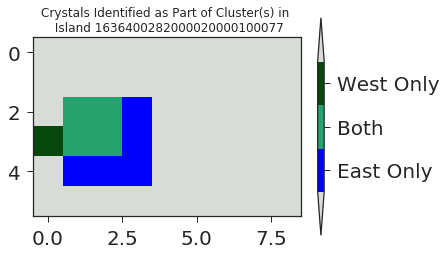

Unique island:  1636400282000020000100064 (entry 40 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000020000100063 (entry 41 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000020000100062 (entry 42 )
     KS Result:  0.9524779094415622
Unique island:  1636400282000020000100067 (entry 44 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000020000100065 (entry 45 )
     KS Result:  0.9919638849816804
Unique island:  1636400282000020000100071 (entry 46 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000020000100066 (entry 47 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000020000100074 (entry 48 )
     KS Result:  0.9935246171107573
Unique island:  1636400282000020000100079 (entry 50 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000020000100083 (entry 51 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000020000100068 (entry 52 )
     KS Result:  0.8855519111836548
Unique isl

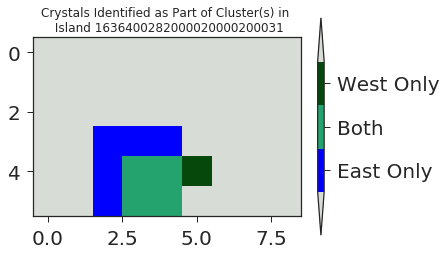

Unique island:  1636400282000020000200021 (entry 114 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000020000200038 (entry 115 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000020000200017 (entry 116 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000020000200006 (entry 117 )
     KS Result:  0.9633153499870267
Unique island:  1636400282000020000200026 (entry 118 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000020000200037 (entry 119 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000020000200027 (entry 120 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000020000200029 (entry 121 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000020000200046 (entry 122 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000020000200040 (entry 123 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000020000200022 (entry 124 )
     KS Result:  0.9639452437314864

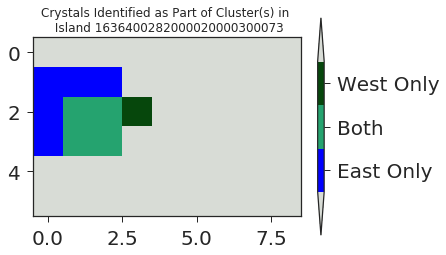

Unique island:  1636400282000020000300080 (entry 253 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000020000300075 (entry 254 )
     KS Result:  0.796412508578516
Unique island:  1636400282000020000300077 (entry 255 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000020000300082 (entry 256 )
     KS Result:  0.998265735388435
Unique island:  1636400282000020000300074 (entry 257 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000020000300081 (entry 258 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000020000300078 (entry 259 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000020000300085 (entry 260 )
     KS Result:  0.998265735388435
Unique island:  1636400282000020000300084 (entry 261 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000020000300087 (entry 262 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000020000300086 (entry 263 )
     KS Result:  1.0
Unique island:  1

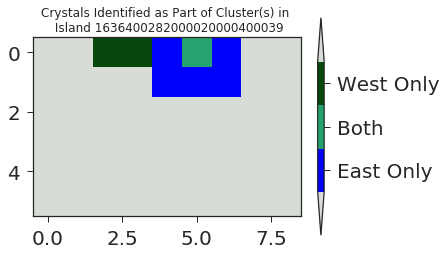

Unique island:  1636400282000020000400049 (entry 325 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000020000400048 (entry 326 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000020000400051 (entry 327 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000020000400053 (entry 328 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000020000400058 (entry 329 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000020000400057 (entry 330 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000020000400063 (entry 331 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000020000400065 (entry 332 )
     KS Result:  0.9513037360389418
Unique island:  1636400282000020000400087 (entry 333 )
     KS Result:  0.8855519111836548
Unique island:  1636400282000020000400070 (entry 335 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000020000400071 (entry 336 )
     KS Result:  0.8855519111836548

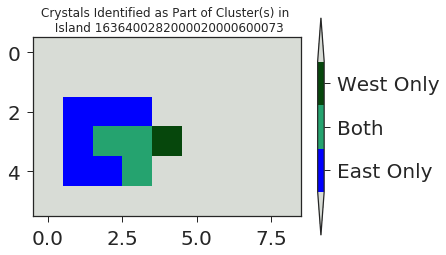

Unique island:  1636400282000020000600071 (entry 537 )
     KS Result:  0.9999441982429496
Unique island:  1636400282000020000600080 (entry 538 )
     KS Result:  0.9991812273728923
Unique island:  1636400282000020000600069 (entry 539 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000020000600074 (entry 540 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000020000600078 (entry 541 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000020000600076 (entry 542 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000020000600079 (entry 543 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000020000600081 (entry 544 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000020000600082 (entry 545 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000020000600086 (entry 546 )
     KS Result:  0.8855519111836548
Unique island:  1636400282000020000600085 (entry 547 )
     KS Result:  0.9569647356345463

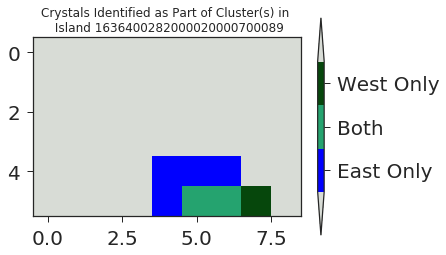

Unique island:  1636400282000020000700083 (entry 631 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000020000700103 (entry 632 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000020000700099 (entry 633 )
     KS Result:  1.0
Unique island:  1636400282000020000700095 (entry 634 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000020000700093 (entry 635 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000020000700098 (entry 636 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000020000700096 (entry 637 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000020000700097 (entry 638 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000020000700106 (entry 639 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000020000700101 (entry 640 )
     KS Result:  0.978035935356541
Unique island:  1636400282000020000700104 (entry 641 )
     KS Result:  0.998265735388435
Unique island:  

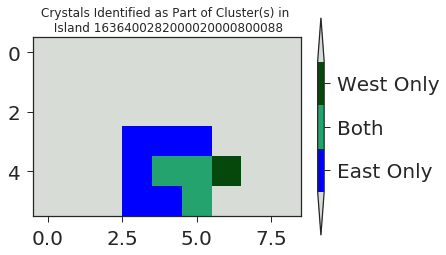

Unique island:  1636400282000020000800090 (entry 719 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000020000800089 (entry 720 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000020000800097 (entry 721 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000020000800095 (entry 722 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000020000800091 (entry 723 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000020000800094 (entry 724 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000020000800096 (entry 725 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000020000800093 (entry 726 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000020000800100 (entry 727 )
     KS Result:  0.8402484746377933
Unique island:  1636400282000020000800098 (entry 728 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000020000800102 (entry 729 )
     KS Result:  0.9324454652858934

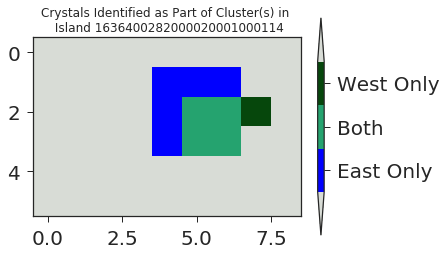

Unique island:  1636400282000020001000115 (entry 929 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000020001000117 (entry 930 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000020001000118 (entry 931 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000020001100035 (entry 932 )
     KS Result:  0.9513037360389418
Unique island:  1636400282000020001100031 (entry 933 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000020001100026 (entry 934 )
     KS Result:  0.998265735388435
Unique island:  1636400282000020001100044 (entry 935 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000020001100036 (entry 936 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000020001100023 (entry 937 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000020001100046 (entry 938 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000020001100015 (entry 939 )
     KS Result:  0.8588498786512343


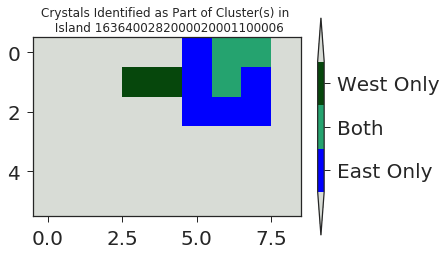

Unique island:  1636400282000020001100049 (entry 965 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000020001100033 (entry 966 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000020001100013 (entry 967 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000020001100057 (entry 968 )
     KS Result:  0.9513037360389418
Unique island:  1636400282000020001100056 (entry 969 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000020001100060 (entry 970 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000020001100061 (entry 971 )
     KS Result:  0.9513037360389418
Unique island:  1636400282000020001100059 (entry 972 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000020001100062 (entry 973 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000020001100064 (entry 974 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000020001100100 (entry 975 )
     KS Result:  0.7316317556789458

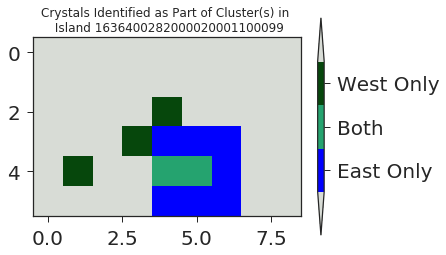

Unique island:  1636400282000020001100098 (entry 1012 )
     KS Result:  0.6870911965696748
Unique island:  1636400282000020001100101 (entry 1013 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000020001100102 (entry 1014 )
     KS Result:  0.998265735388435
Unique island:  1636400282000020001100105 (entry 1015 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000020001100104 (entry 1016 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000020001100103 (entry 1017 )
     KS Result:  0.765763173908239
Unique island:  1636400282000020001100106 (entry 1018 )
     KS Result:  0.8884604030744513
Unique island:  1636400282000020001100107 (entry 1019 )
     KS Result:  0.9999441982429496
Unique island:  1636400282000020001100110 (entry 1020 )
     KS Result:  0.994241144886877
Unique island:  1636400282000020001100108 (entry 1021 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000020001100109 (entry 1022 )
     KS Result:  0.75909783

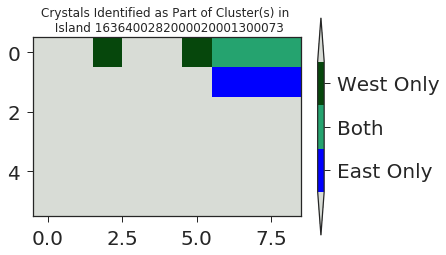

Unique island:  1636400282000020001300070 (entry 1162 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000020001300069 (entry 1163 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000020001300075 (entry 1164 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000020001300072 (entry 1165 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000020001300077 (entry 1166 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000020001300081 (entry 1167 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000020001300080 (entry 1168 )
     KS Result:  0.9993741425663383
Unique island:  1636400282000020001300079 (entry 1169 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000020001300082 (entry 1170 )
     KS Result:  0.998265735388435
Unique island:  1636400282000020001300084 (entry 1171 )
     KS Result:  0.8402484746377933
Unique island:  1636400282000020001300098 (entry 1172 )
     KS Result:  0.644693

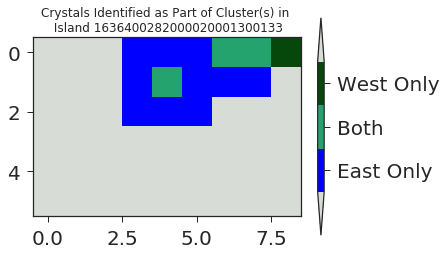

Unique island:  1636400282000020001300134 (entry 1228 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000020001400035 (entry 1229 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000020001400024 (entry 1230 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000020001400032 (entry 1231 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000020001400038 (entry 1232 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000020001400019 (entry 1233 )
     KS Result:  0.999965230654072
Unique island:  1636400282000020001400026 (entry 1234 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000020001400042 (entry 1235 )
     KS Result:  0.9997921317248424
Unique island:  1636400282000020001400017 (entry 1237 )
     KS Result:  0.9560244942882422
Unique island:  1636400282000020001400016 (entry 1238 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000020001400036 (entry 1239 )
     KS Result:  0.918018

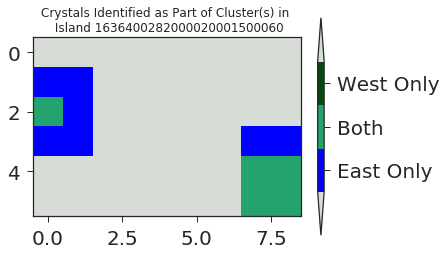

Unique island:  1636400282000020001500005 (entry 1337 )
     KS Result:  0.994241144886877
Unique island:  1636400282000020001500026 (entry 1338 )
     KS Result:  0.8855519111836548
Unique island:  1636400282000020001500047 (entry 1339 )
     KS Result:  0.9513037360389418
Unique island:  1636400282000020001500013 (entry 1340 )
     KS Result:  0.9762589132952211
Unique island:  1636400282000020001500032 (entry 1341 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000020001500027 (entry 1342 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000020001500030 (entry 1343 )
     KS Result:  0.765763173908239
Unique island:  1636400282000020001500031 (entry 1344 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000020001500006 (entry 1345 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000020001500033 (entry 1346 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000020001500009 (entry 1347 )
     KS Result:  0.9639452

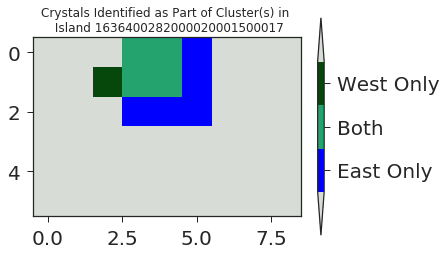

Unique island:  1636400282000020001500010 (entry 1349 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000020001500035 (entry 1350 )
     KS Result:  0.759097838865462
Unique island:  1636400282000020001500020 (entry 1351 )
     KS Result:  0.998265735388435
Unique island:  1636400282000020001500040 (entry 1352 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000020001500036 (entry 1353 )
     KS Result:  0.9513037360389418
Unique island:  1636400282000020001500015 (entry 1354 )
     KS Result:  0.9793631144957665
Unique island:  1636400282000020001500041 (entry 1355 )
     KS Result:  0.9999999955914529
Unique island:  1636400282000020001500023 (entry 1356 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000020001500039 (entry 1357 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000020001500061 (entry 1358 )
     KS Result:  0.9605340057621666
Unique island:  1636400282000020001500043 (entry 1360 )
     KS Result:  0.9030083

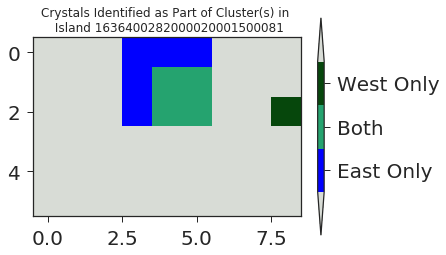

Unique island:  1636400282000020001500068 (entry 1403 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000020001500078 (entry 1404 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000020001500082 (entry 1405 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000020001500075 (entry 1406 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000020001500079 (entry 1407 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000020001500087 (entry 1408 )
     KS Result:  0.994241144886877
Unique island:  1636400282000020001500070 (entry 1409 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000020001500084 (entry 1410 )
     KS Result:  0.9999998168087756
Unique island:  1636400282000020001500089 (entry 1411 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000020001500086 (entry 1412 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000020001500091 (entry 1413 )
     KS Result:  0.999944

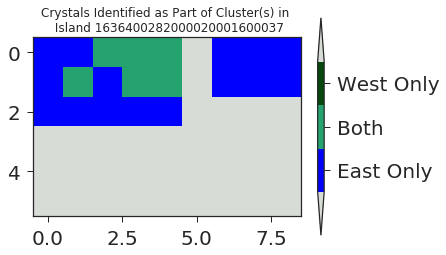

Unique island:  1636400282000020001600006 (entry 1468 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000020001600059 (entry 1469 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000020001600047 (entry 1471 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000020001600010 (entry 1472 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000020001600017 (entry 1473 )
     KS Result:  0.765763173908239
Unique island:  1636400282000020001600028 (entry 1474 )
     KS Result:  0.9513037360389418
Unique island:  1636400282000020001600034 (entry 1475 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000020001600049 (entry 1476 )
     KS Result:  0.9725638520198123
Unique island:  1636400282000020001600043 (entry 1477 )
     KS Result:  0.9919638849816804
Unique island:  1636400282000020001600003 (entry 1478 )
     KS Result:  0.994241144886877
Unique island:  1636400282000020001600026 (entry 1479 )
     KS Result:  0.9030083

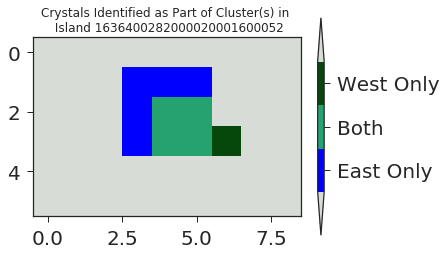

Unique island:  1636400282000020001600053 (entry 1493 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000020001600048 (entry 1494 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000020001600055 (entry 1495 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000020001600054 (entry 1496 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000020001600061 (entry 1497 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000020001600063 (entry 1498 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000020001600062 (entry 1499 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000020001600072 (entry 1500 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000020001600070 (entry 1501 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000020001600075 (entry 1502 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000020001600066 (entry 1503 )
     KS Result:  0.90300

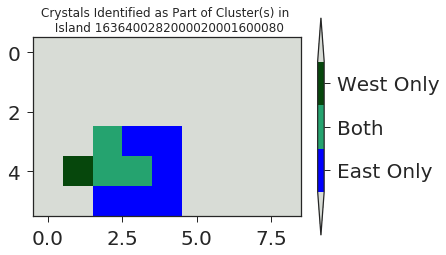

Unique island:  1636400282000020001600084 (entry 1520 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000020001600074 (entry 1521 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000020001600093 (entry 1522 )
     KS Result:  0.9500673597842684
Unique island:  1636400282000020001600081 (entry 1524 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000020001600082 (entry 1525 )
     KS Result:  0.9582639842956672
Unique island:  1636400282000020001600088 (entry 1526 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000020001600090 (entry 1527 )
     KS Result:  0.9999881693234195
Unique island:  1636400282000020001600087 (entry 1528 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000020001600089 (entry 1529 )
     KS Result:  0.9513037360389418
Unique island:  1636400282000020001600091 (entry 1530 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000020001600092 (entry 1531 )
     KS Result:  0.90300

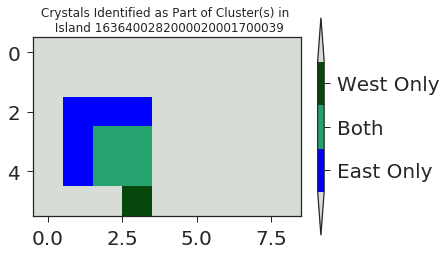

Unique island:  1636400282000020001700060 (entry 1597 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000020001700056 (entry 1598 )
     KS Result:  0.8855519111836548
Unique island:  1636400282000020001700067 (entry 1599 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000020001700042 (entry 1600 )
     KS Result:  0.0


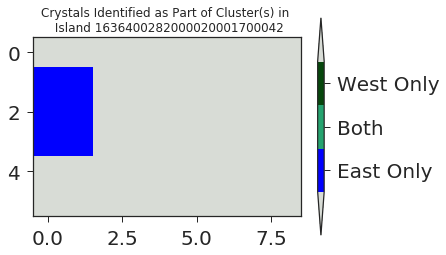

Unique island:  1636400282000020001700069 (entry 1601 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000020001700074 (entry 1602 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000020001700072 (entry 1603 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000020001700098 (entry 1604 )
     KS Result:  0.996704799636122
Unique island:  1636400282000020001700071 (entry 1606 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000020001700076 (entry 1607 )
     KS Result:  0.994241144886877
Unique island:  1636400282000020001700078 (entry 1608 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000020001700089 (entry 1609 )
     KS Result:  0.9515985792330526
Unique island:  1636400282000020001700088 (entry 1611 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000020001700079 (entry 1612 )
     KS Result:  0.765763173908239
Unique island:  1636400282000020001700087 (entry 1613 )
     KS Result:  0.95130373

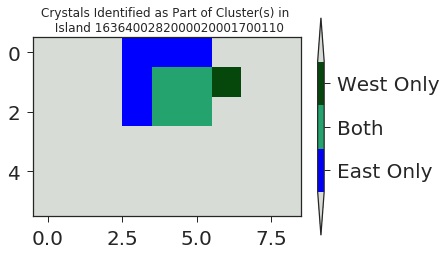

Unique island:  1636400282000020001700111 (entry 1643 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000020001800023 (entry 1644 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000020001800033 (entry 1645 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000020001800034 (entry 1646 )
     KS Result:  0.8781816046495938
Unique island:  1636400282000020001800035 (entry 1647 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000020001800019 (entry 1648 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000020001800032 (entry 1649 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000020001800027 (entry 1650 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000020001800046 (entry 1651 )
     KS Result:  0.7869237102295524
Unique island:  1636400282000020001800014 (entry 1653 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000020001800025 (entry 1654 )
     KS Result:  0.97936

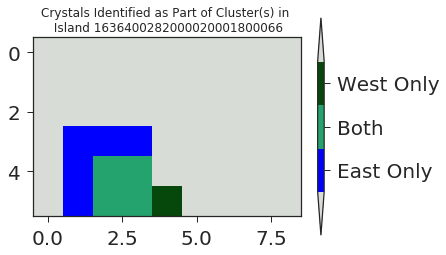

Unique island:  1636400282000020001800068 (entry 1696 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000020001800074 (entry 1697 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000020001800069 (entry 1698 )
     KS Result:  0.9868227984173787
Unique island:  1636400282000020001800075 (entry 1699 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000020001800071 (entry 1700 )
     KS Result:  0.9793631144957665
Unique island:  1636400282000020001800072 (entry 1701 )
     KS Result:  0.998265735388435
Unique island:  1636400282000020001800070 (entry 1702 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000020001800079 (entry 1703 )
     KS Result:  0.9999999108142551
Unique island:  1636400282000020001800077 (entry 1704 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000020001800076 (entry 1705 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000020001800078 (entry 1706 )
     KS Result:  0.918018

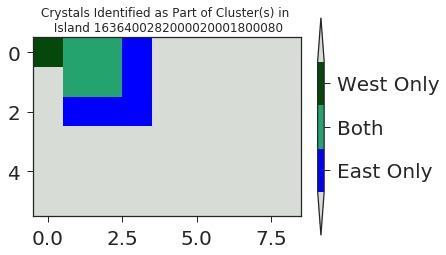

Unique island:  1636400282000020001800082 (entry 1710 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000020001800083 (entry 1711 )
     KS Result:  0.9999441982429496
Unique island:  1636400282000020001800084 (entry 1712 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000020001800086 (entry 1713 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000020001800085 (entry 1714 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000020001800088 (entry 1715 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000020001800087 (entry 1716 )
     KS Result:  0.8079241602959086
Unique island:  1636400282000020001800089 (entry 1717 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000020001800090 (entry 1718 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000020001900037 (entry 1719 )
     KS Result:  0.9524779094415624
Unique island:  1636400282000020001900001 (entry 1720 )
     KS Result:  0.93244

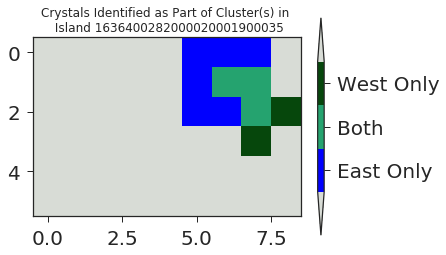

Unique island:  1636400282000020001900014 (entry 1736 )
     KS Result:  0.9882610776652121
Unique island:  1636400282000020001900043 (entry 1737 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000020001900013 (entry 1738 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000020001900044 (entry 1739 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000020001900017 (entry 1740 )
     KS Result:  0.6092888474528326
Unique island:  1636400282000020001900038 (entry 1741 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000020001900015 (entry 1742 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000020001900040 (entry 1743 )
     KS Result:  0.8674258676307467
Unique island:  1636400282000020001900036 (entry 1744 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000020001900039 (entry 1745 )
     KS Result:  0.920740593169981
Unique island:  1636400282000020001900031 (entry 1747 )
     KS Result:  0.932445

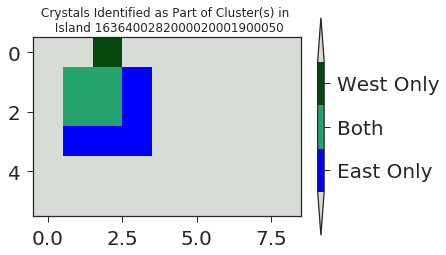

Unique island:  1636400282000020001900048 (entry 1759 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000020001900046 (entry 1760 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000020001900049 (entry 1761 )
     KS Result:  0.998265735388435
Unique island:  1636400282000020001900060 (entry 1762 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000020001900063 (entry 1763 )
     KS Result:  0.999965230654072
Unique island:  1636400282000020001900069 (entry 1764 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000020001900059 (entry 1765 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000020001900056 (entry 1766 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000020001900053 (entry 1767 )
     KS Result:  0.592502831138744


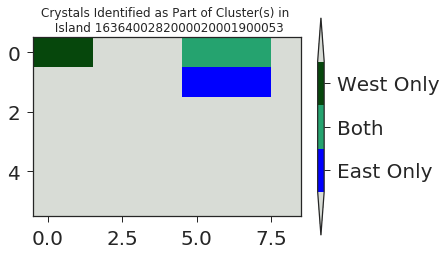

Unique island:  1636400282000020001900054 (entry 1768 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000020001900061 (entry 1769 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000020001900057 (entry 1770 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000020001900055 (entry 1771 )
     KS Result:  0.9919638849816804
Unique island:  1636400282000020001900065 (entry 1772 )
     KS Result:  0.9999913128204173
Unique island:  1636400282000020001900058 (entry 1773 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000020001900071 (entry 1774 )
     KS Result:  0.998265735388435
Unique island:  1636400282000020001900072 (entry 1775 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000020001900074 (entry 1776 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000020001900064 (entry 1777 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000020001900070 (entry 1778 )
     KS Result:  0.985279

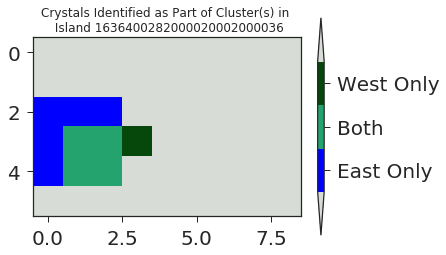

Unique island:  1636400282000020002000048 (entry 1837 )
     KS Result:  0.7086028444910495
Unique island:  1636400282000020002000044 (entry 1840 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000020002000025 (entry 1841 )
     KS Result:  0.8899057827323222
Unique island:  1636400282000020002000030 (entry 1842 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000020002000035 (entry 1843 )
     KS Result:  0.8855519111836548
Unique island:  1636400282000020002000010 (entry 1844 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000020002000007 (entry 1845 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000020002000023 (entry 1846 )
     KS Result:  0.998265735388435
Unique island:  1636400282000020002000017 (entry 1847 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000020002000037 (entry 1848 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000020002000046 (entry 1849 )
     KS Result:  0.994801

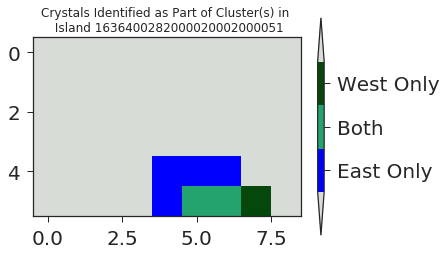

Unique island:  1636400282000020002000055 (entry 1855 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000020002000061 (entry 1856 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000020002000050 (entry 1857 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000020002000057 (entry 1858 )
     KS Result:  0.8884604030744513
Unique island:  1636400282000020002000064 (entry 1860 )
     KS Result:  0.998265735388435
Unique island:  1636400282000020002000056 (entry 1861 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000020002000071 (entry 1862 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000020002000059 (entry 1863 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000020002000054 (entry 1864 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000020002000066 (entry 1865 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000020002000073 (entry 1866 )
     KS Result:  1.0
Uniq

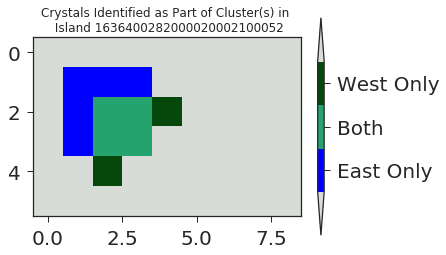

Unique island:  1636400282000020002100068 (entry 1945 )
     KS Result:  0.9762589132952212
Unique island:  1636400282000020002100056 (entry 1946 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000020002100065 (entry 1947 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000020002100061 (entry 1948 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000020002100064 (entry 1949 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000020002100049 (entry 1950 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000020002100033 (entry 1951 )
     KS Result:  0.994241144886877
Unique island:  1636400282000020002100067 (entry 1952 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000020002100071 (entry 1953 )
     KS Result:  0.765763173908239
Unique island:  1636400282000020002100078 (entry 1954 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000020002100072 (entry 1955 )
     KS Result:  0.9513037

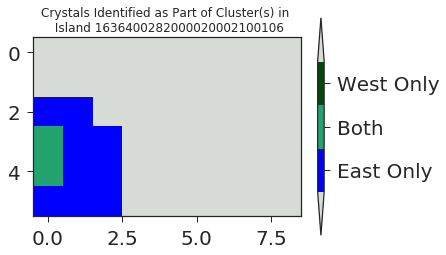

Unique island:  1636400282000020002100108 (entry 1991 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000020002100109 (entry 1992 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000020002100111 (entry 1993 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000020002100113 (entry 1994 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000020002100110 (entry 1995 )
     KS Result:  0.765763173908239
Unique island:  1636400282000020002100114 (entry 1996 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000020002100112 (entry 1997 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000020002100115 (entry 1998 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000020002100116 (entry 1999 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000020002200023 (entry 2000 )
     KS Result:  0.994241144886877
Unique island:  1636400282000020002200014 (entry 2001 )
     KS Result:  0.9999842

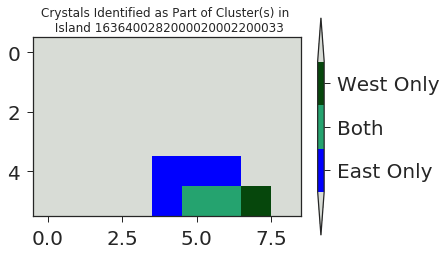

Unique island:  1636400282000020002200042 (entry 2032 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000020002200037 (entry 2033 )
     KS Result:  0.6870911965696748
Unique island:  1636400282000020002200046 (entry 2034 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000020002200032 (entry 2035 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000020002200047 (entry 2036 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000020002200053 (entry 2037 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000020002200058 (entry 2038 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000020002200051 (entry 2039 )
     KS Result:  0.994241144886877
Unique island:  1636400282000020002200052 (entry 2040 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000020002200064 (entry 2041 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000020002200071 (entry 2042 )
     KS Result:  0.989848

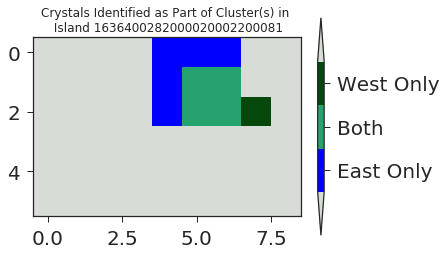

Unique island:  1636400282000020002200074 (entry 2067 )
     KS Result:  0.994241144886877
Unique island:  1636400282000020002200078 (entry 2068 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000020002200080 (entry 2069 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000020002200083 (entry 2070 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000020002200086 (entry 2071 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000020002200085 (entry 2072 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000020002200084 (entry 2073 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000020002200087 (entry 2074 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000020002200088 (entry 2075 )
     KS Result:  0.6870911965696748
Unique island:  1636400282000020002200089 (entry 2076 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000020002200091 (entry 2077 )
     KS Result:  0.918018

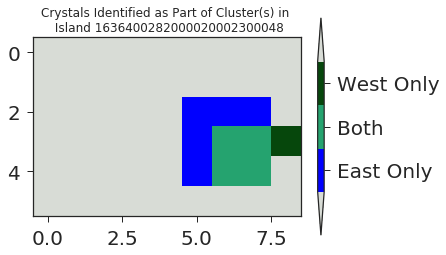

Unique island:  1636400282000020002300045 (entry 2117 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000020002300018 (entry 2118 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000020002300017 (entry 2119 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000020002300016 (entry 2120 )
     KS Result:  0.994241144886877
Unique island:  1636400282000020002300042 (entry 2121 )
     KS Result:  0.8402484746377933
Unique island:  1636400282000020002300025 (entry 2122 )
     KS Result:  0.759097838865462
Unique island:  1636400282000020002300031 (entry 2123 )
     KS Result:  0.6870911965696748
Unique island:  1636400282000020002300012 (entry 2124 )
     KS Result:  0.7989513620291605
Unique island:  1636400282000020002300050 (entry 2125 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000020002300020 (entry 2126 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000020002300036 (entry 2127 )
     KS Result:  0.6870911

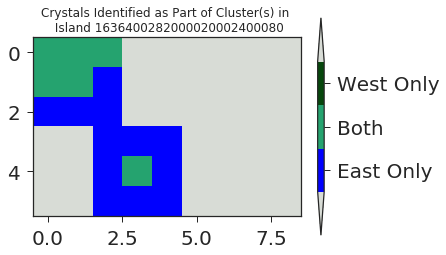

Unique island:  1636400282000020002400066 (entry 2231 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000020002400034 (entry 2232 )
     KS Result:  0.9513037360389418
Unique island:  1636400282000020002400061 (entry 2233 )
     KS Result:  0.8855519111836548
Unique island:  1636400282000020002400091 (entry 2234 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000020002400083 (entry 2235 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000020002400081 (entry 2236 )
     KS Result:  0.994241144886877
Unique island:  1636400282000020002400082 (entry 2237 )
     KS Result:  0.994241144886877
Unique island:  1636400282000020002400095 (entry 2238 )
     KS Result:  0.9907163119347335
Unique island:  1636400282000020002400092 (entry 2239 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000020002400088 (entry 2240 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000020002400084 (entry 2241 )
     KS Result:  0.7657631

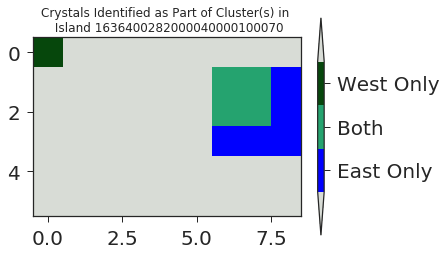

Unique island:  1636400282000040000100068 (entry 2358 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000040000100076 (entry 2359 )
     KS Result:  0.9973497468567775
Unique island:  1636400282000040000100072 (entry 2360 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000040000100071 (entry 2361 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000040000100073 (entry 2362 )
     KS Result:  0.9667907605546224
Unique island:  1636400282000040000100077 (entry 2363 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000040000100078 (entry 2364 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000040000100079 (entry 2365 )
     KS Result:  0.759097838865462
Unique island:  1636400282000040000100082 (entry 2366 )
     KS Result:  0.9919638849816804
Unique island:  1636400282000040000100085 (entry 2367 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000040000100081 (entry 2368 )
     KS Result:  0.872844

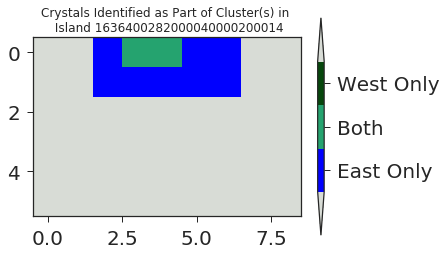

Unique island:  1636400282000040000200024 (entry 2391 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000040000200019 (entry 2392 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000040000200030 (entry 2393 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000040000200012 (entry 2394 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000040000200049 (entry 2395 )
     KS Result:  0.9999441982429496
Unique island:  1636400282000040000200037 (entry 2397 )
     KS Result:  0.9991812273728923
Unique island:  1636400282000040000200029 (entry 2398 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000040000200040 (entry 2399 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000040000200036 (entry 2400 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000040000200031 (entry 2401 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000040000200035 (entry 2402 )
     KS Result:  0.69937

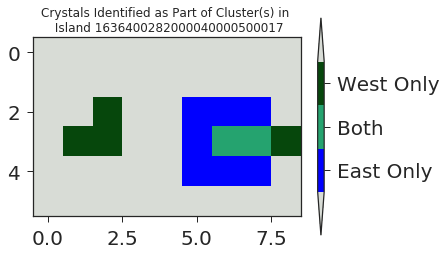

Unique island:  1636400282000040000500048 (entry 2604 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000040000500050 (entry 2605 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000040000500044 (entry 2606 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000040000500043 (entry 2607 )
     KS Result:  0.759097838865462
Unique island:  1636400282000040000500045 (entry 2608 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000040000500049 (entry 2609 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000040000500015 (entry 2610 )
     KS Result:  0.759097838865462
Unique island:  1636400282000040000500013 (entry 2611 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000040000500035 (entry 2612 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000040000500009 (entry 2613 )
     KS Result:  0.994241144886877
Unique island:  1636400282000040000500046 (entry 2614 )
     KS Result:  0.95696473

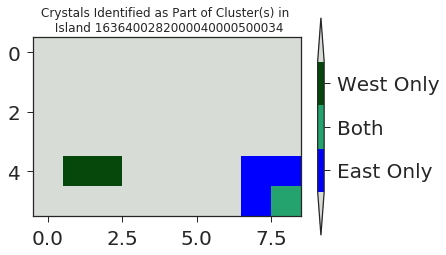

Unique island:  1636400282000040000500030 (entry 2624 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000040000500039 (entry 2625 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000040000500033 (entry 2626 )
     KS Result:  0.8855519111836548
Unique island:  1636400282000040000500052 (entry 2627 )
     KS Result:  0.8855519111836548
Unique island:  1636400282000040000500031 (entry 2628 )
     KS Result:  0.8781816046495938
Unique island:  1636400282000040000500055 (entry 2629 )
     KS Result:  0.9793631144957665
Unique island:  1636400282000040000500051 (entry 2630 )
     KS Result:  0.9793631144957665
Unique island:  1636400282000040000500056 (entry 2631 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000040000500059 (entry 2632 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000040000500062 (entry 2633 )
     KS Result:  0.9852795287266235
Unique island:  1636400282000040000500058 (entry 2635 )
     KS Result:  0.96394

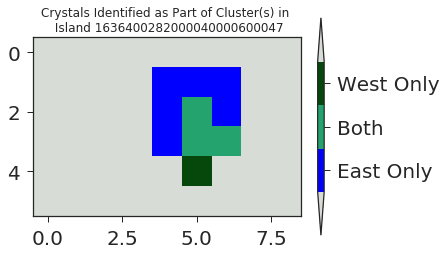

Unique island:  1636400282000040000600051 (entry 2713 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000040000600056 (entry 2714 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000040000600055 (entry 2715 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000040000600052 (entry 2716 )
     KS Result:  0.9962551923863173
Unique island:  1636400282000040000600061 (entry 2717 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000040000600063 (entry 2718 )
     KS Result:  0.999965230654072
Unique island:  1636400282000040000600064 (entry 2719 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000040000600069 (entry 2720 )
     KS Result:  0.998265735388435
Unique island:  1636400282000040000600066 (entry 2721 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000040000600058 (entry 2722 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000040000600062 (entry 2723 )
     KS Result:  0.9030083

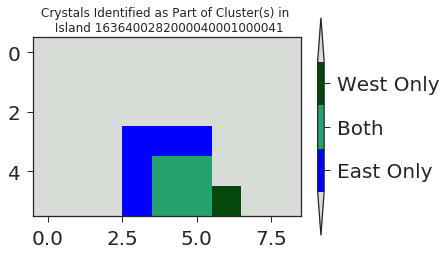

Unique island:  1636400282000040001000042 (entry 2985 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000040001000048 (entry 2986 )
     KS Result:  0.759097838865462
Unique island:  1636400282000040001000055 (entry 2987 )
     KS Result:  0.999965230654072
Unique island:  1636400282000040001000026 (entry 2988 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000040001000022 (entry 2989 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000040001000013 (entry 2990 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000040001000012 (entry 2991 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000040001000018 (entry 2992 )
     KS Result:  0.6870911965696748
Unique island:  1636400282000040001000023 (entry 2993 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000040001000052 (entry 2994 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000040001000049 (entry 2995 )
     KS Result:  0.9439727

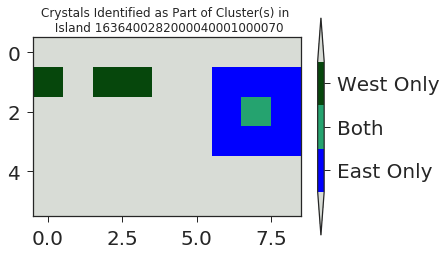

Unique island:  1636400282000040001000072 (entry 3026 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000040001000076 (entry 3027 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000040001000082 (entry 3028 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000040001000080 (entry 3029 )
     KS Result:  0.9999999955914529
Unique island:  1636400282000040001000085 (entry 3030 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000040001000077 (entry 3031 )
     KS Result:  0.998265735388435
Unique island:  1636400282000040001000086 (entry 3032 )
     KS Result:  0.9793631144957665
Unique island:  1636400282000040001000079 (entry 3033 )
     KS Result:  0.55955971019521


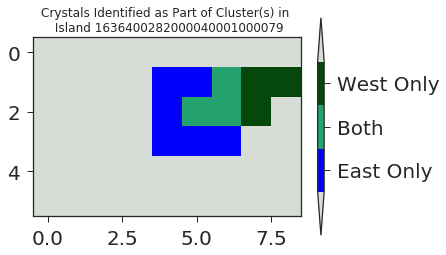

Unique island:  1636400282000040001000074 (entry 3034 )
     KS Result:  0.9582639842956673
Unique island:  1636400282000040001000081 (entry 3035 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000040001000084 (entry 3036 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000040001000075 (entry 3037 )
     KS Result:  0.9793631144957665
Unique island:  1636400282000040001000083 (entry 3038 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000040001000088 (entry 3039 )
     KS Result:  0.765763173908239
Unique island:  1636400282000040001000089 (entry 3040 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000040001000090 (entry 3041 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000040001000091 (entry 3042 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000040001000094 (entry 3043 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000040001000095 (entry 3044 )
     KS Result:  0.918018

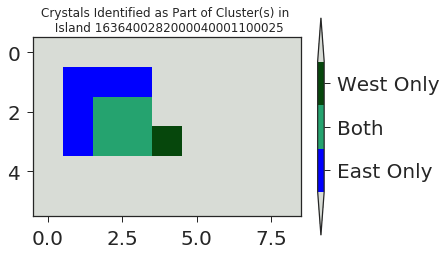

Unique island:  1636400282000040001100034 (entry 3062 )
     KS Result:  0.9524779094415624
Unique island:  1636400282000040001100035 (entry 3063 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000040001100022 (entry 3064 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000040001100021 (entry 3065 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000040001100017 (entry 3066 )
     KS Result:  0.6870911965696748
Unique island:  1636400282000040001100008 (entry 3067 )
     KS Result:  0.6271670424650708
Unique island:  1636400282000040001100018 (entry 3068 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000040001100040 (entry 3069 )
     KS Result:  0.9907163119347335
Unique island:  1636400282000040001100039 (entry 3070 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000040001100023 (entry 3071 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000040001100010 (entry 3072 )
     KS Result:  0.90300

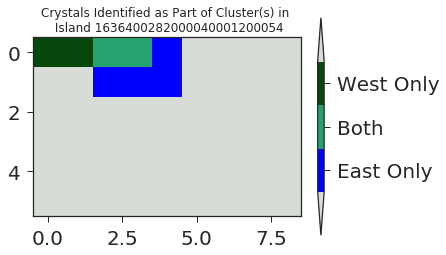

Unique island:  1636400282000040001200057 (entry 3163 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000040001200069 (entry 3164 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000040001200065 (entry 3165 )
     KS Result:  0.9180184255186957
Unique island:  1636400282000040001200070 (entry 3166 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000040001200063 (entry 3167 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000040001200066 (entry 3168 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000040001200058 (entry 3169 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000040001200068 (entry 3170 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000040001200064 (entry 3171 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000040001200061 (entry 3172 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000040001200071 (entry 3173 )
     KS Result:  0.97936

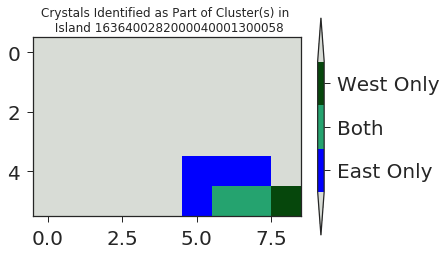

Unique island:  1636400282000040001300068 (entry 3246 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000040001300072 (entry 3247 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000040001300060 (entry 3248 )
     KS Result:  0.6101641028461858
Unique island:  1636400282000040001300065 (entry 3249 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000040001300066 (entry 3250 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000040001300062 (entry 3252 )
     KS Result:  0.9919638849816804
Unique island:  1636400282000040001300070 (entry 3253 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000040001300071 (entry 3254 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000040001300075 (entry 3255 )
     KS Result:  0.765763173908239
Unique island:  1636400282000040001300076 (entry 3256 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000040001300074 (entry 3257 )
     KS Result:  0.963945

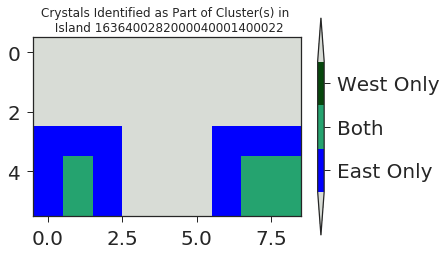

Unique island:  1636400282000040001400017 (entry 3286 )
     KS Result:  0.998265735388435
Unique island:  1636400282000040001400031 (entry 3287 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000040001400025 (entry 3288 )
     KS Result:  0.998265735388435
Unique island:  1636400282000040001400021 (entry 3289 )
     KS Result:  0.8630553160664483
Unique island:  1636400282000040001400026 (entry 3290 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000040001400019 (entry 3291 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000040001400013 (entry 3292 )
     KS Result:  0.998265735388435
Unique island:  1636400282000040001400007 (entry 3293 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000040001400032 (entry 3294 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000040001400029 (entry 3295 )
     KS Result:  0.998265735388435
Unique island:  1636400282000040001400014 (entry 3296 )
     KS Result:  0.644693629

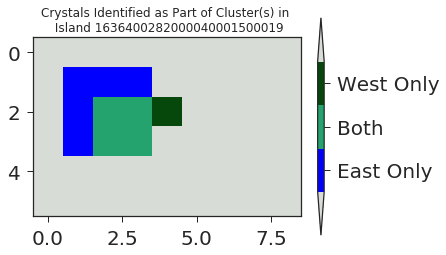

Unique island:  1636400282000040001500007 (entry 3377 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000040001500006 (entry 3378 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000040001500003 (entry 3379 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000040001500036 (entry 3380 )
     KS Result:  0.9793631144957665
Unique island:  1636400282000040001500020 (entry 3381 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000040001500011 (entry 3382 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000040001500016 (entry 3383 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000040001500043 (entry 3384 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000040001500021 (entry 3385 )
     KS Result:  0.998265735388435
Unique island:  1636400282000040001500027 (entry 3386 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000040001500034 (entry 3387 )
     KS Result:  0.999633

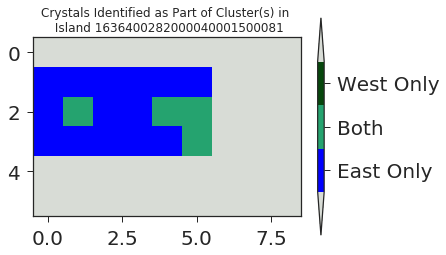

Unique island:  1636400282000040001500083 (entry 3438 )
     KS Result:  0.998265735388435
Unique island:  1636400282000040001500082 (entry 3439 )
     KS Result:  0.9882610776652121
Unique island:  1636400282000040001500084 (entry 3440 )
     KS Result:  0.6870911965696748
Unique island:  1636400282000040001500088 (entry 3441 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000040001500087 (entry 3442 )
     KS Result:  0.8781816046495938
Unique island:  1636400282000040001500086 (entry 3443 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000040001500089 (entry 3444 )
     KS Result:  0.9180184255186957
Unique island:  1636400282000040001500085 (entry 3445 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000040001500090 (entry 3446 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000040001500091 (entry 3447 )
     KS Result:  0.766201553700294
Unique island:  1636400282000040001500092 (entry 3449 )
     KS Result:  0.9982657

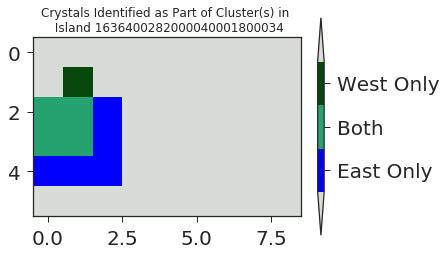

Unique island:  1636400282000040001800017 (entry 3620 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000040001800041 (entry 3621 )
     KS Result:  0.9513037360389418
Unique island:  1636400282000040001800036 (entry 3622 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000040001800004 (entry 3623 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000040001800029 (entry 3624 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000040001800018 (entry 3625 )
     KS Result:  0.9513037360389418
Unique island:  1636400282000040001800031 (entry 3626 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000040001800006 (entry 3627 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000040001800010 (entry 3628 )
     KS Result:  0.9950665063958158
Unique island:  1636400282000040001800037 (entry 3629 )
     KS Result:  0.8402484746377933
Unique island:  1636400282000040001800015 (entry 3630 )
     KS Result:  0.99049

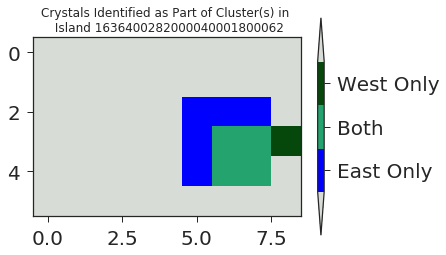

Unique island:  1636400282000040001800059 (entry 3665 )
     KS Result:  0.7989513620291606
Unique island:  1636400282000040001800076 (entry 3667 )
     KS Result:  0.9524779094415622
Unique island:  1636400282000040001800072 (entry 3669 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000040001800073 (entry 3670 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000040001800066 (entry 3671 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000040001800067 (entry 3672 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000040001800069 (entry 3673 )
     KS Result:  0.998265735388435
Unique island:  1636400282000040001800071 (entry 3674 )
     KS Result:  0.8855519111836548
Unique island:  1636400282000040001800065 (entry 3675 )
     KS Result:  0.759097838865462
Unique island:  1636400282000040001800074 (entry 3676 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000040001800068 (entry 3677 )
     KS Result:  0.9904917

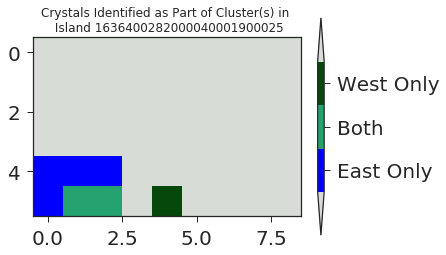

Unique island:  1636400282000040001900005 (entry 3720 )
     KS Result:  0.6464668052400346
Unique island:  1636400282000040001900016 (entry 3721 )
     KS Result:  0.9188342107778236
Unique island:  1636400282000040001900029 (entry 3722 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000040001900017 (entry 3723 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000040001900038 (entry 3724 )
     KS Result:  1.0
Unique island:  1636400282000040001900010 (entry 3725 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000040001900027 (entry 3726 )
     KS Result:  0.995066506395816
Unique island:  1636400282000040001900022 (entry 3727 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000040001900043 (entry 3728 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000040001900041 (entry 3729 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000040001900044 (entry 3730 )
     KS Result:  0.9569647356345463
Uniq

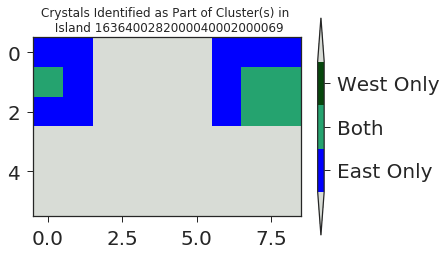

Unique island:  1636400282000040002000066 (entry 3822 )
     KS Result:  0.994241144886877
Unique island:  1636400282000040002000073 (entry 3823 )
     KS Result:  0.9513037360389418
Unique island:  1636400282000040002000068 (entry 3824 )
     KS Result:  0.9513037360389418
Unique island:  1636400282000040002000070 (entry 3825 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000040002000075 (entry 3826 )
     KS Result:  0.998265735388435
Unique island:  1636400282000040002000065 (entry 3827 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000040002000071 (entry 3828 )
     KS Result:  0.978035935356541
Unique island:  1636400282000040002000064 (entry 3829 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000040002000074 (entry 3830 )
     KS Result:  0.9999992291718
Unique island:  1636400282000040002000076 (entry 3831 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000040002000077 (entry 3832 )
     KS Result:  0.76576317390

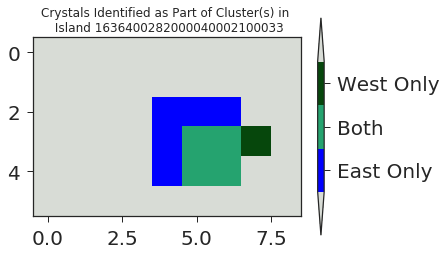

Unique island:  1636400282000040002100016 (entry 3870 )
     KS Result:  0.9882610776652121
Unique island:  1636400282000040002100022 (entry 3871 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000040002100035 (entry 3872 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000040002100008 (entry 3873 )
     KS Result:  0.9439727178931837
Unique island:  1636400282000040002100029 (entry 3874 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000040002100012 (entry 3875 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000040002100020 (entry 3876 )
     KS Result:  0.9639452437314863
Unique island:  1636400282000040002100018 (entry 3877 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000040002100014 (entry 3878 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000040002100019 (entry 3879 )
     KS Result:  0.9999441982429496
Unique island:  1636400282000040002100039 (entry 3881 )
     KS Result:  0.99999

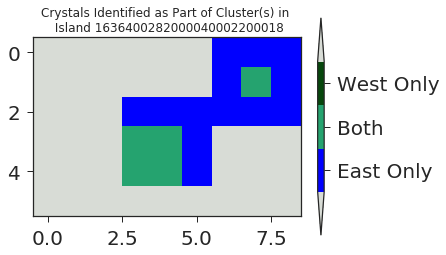

Unique island:  1636400282000040002200038 (entry 3948 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000040002200013 (entry 3949 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000040002200032 (entry 3950 )
     KS Result:  0.998265735388435
Unique island:  1636400282000040002200027 (entry 3951 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000040002200016 (entry 3952 )
     KS Result:  1.0
Unique island:  1636400282000040002200031 (entry 3953 )
     KS Result:  0.9906895533940197
Unique island:  1636400282000040002200025 (entry 3954 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000040002200009 (entry 3955 )
     KS Result:  0.765763173908239
Unique island:  1636400282000040002200024 (entry 3956 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000040002200043 (entry 3957 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000040002200030 (entry 3958 )
     KS Result:  0.9180184255186958
Uniqu

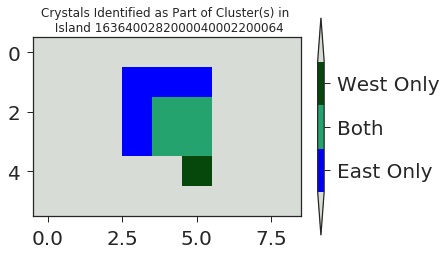

Unique island:  1636400282000040002200063 (entry 3982 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000040002200073 (entry 3983 )
     KS Result:  0.7989513620291605
Unique island:  1636400282000040002200066 (entry 3984 )
     KS Result:  0.994241144886877
Unique island:  1636400282000040002200065 (entry 3985 )
     KS Result:  0.994241144886877
Unique island:  1636400282000040002200067 (entry 3986 )
     KS Result:  0.759097838865462
Unique island:  1636400282000040002200070 (entry 3987 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000040002200083 (entry 3988 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000040002200076 (entry 3989 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000040002200081 (entry 3990 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000040002200072 (entry 3991 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000040002200078 (entry 3992 )
     KS Result:  0.90300836

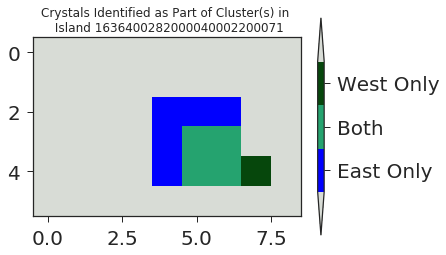

Unique island:  1636400282000040002200069 (entry 4000 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000040002200086 (entry 4001 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000040002200080 (entry 4003 )
     KS Result:  0.9582639842956672
Unique island:  1636400282000040002200085 (entry 4004 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000040002200084 (entry 4005 )
     KS Result:  0.6870911965696748
Unique island:  1636400282000040002200088 (entry 4006 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000040002200087 (entry 4007 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000040002200089 (entry 4008 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000040002200091 (entry 4009 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000040002200090 (entry 4010 )
     KS Result:  0.998265735388435
Unique island:  1636400282000040002200092 (entry 4011 )
     KS Result:  1.0
Uniq

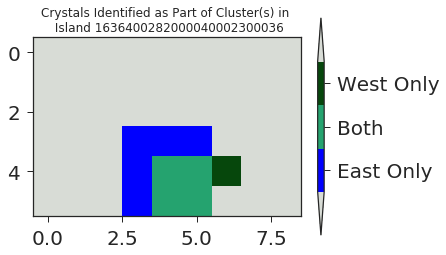

Unique island:  1636400282000040002300009 (entry 4019 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000040002300007 (entry 4020 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000040002300041 (entry 4021 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000040002300026 (entry 4022 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000040002300032 (entry 4023 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000040002300010 (entry 4024 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000040002300029 (entry 4025 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000040002300030 (entry 4026 )
     KS Result:  0.6870911965696748
Unique island:  1636400282000040002300033 (entry 4027 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000040002300028 (entry 4028 )
     KS Result:  0.9513037360389418
Unique island:  1636400282000040002300020 (entry 4029 )
     KS Result:  0.99963

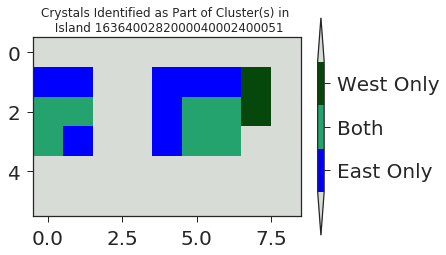

Unique island:  1636400282000040002400040 (entry 4105 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000040002400042 (entry 4106 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000040002400044 (entry 4107 )
     KS Result:  0.765763173908239
Unique island:  1636400282000040002400033 (entry 4108 )
     KS Result:  0.6870911965696748
Unique island:  1636400282000040002400050 (entry 4109 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000040002400052 (entry 4110 )
     KS Result:  0.8855519111836548
Unique island:  1636400282000040002400061 (entry 4111 )
     KS Result:  0.8186211748061034
Unique island:  1636400282000040002400059 (entry 4113 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000040002400064 (entry 4114 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000040002400062 (entry 4115 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000040002400060 (entry 4116 )
     KS Result:  0.994241

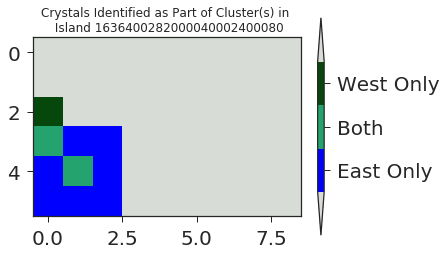

Unique island:  1636400282000040002400088 (entry 4137 )
     KS Result:  0.994241144886877
Unique island:  1636400282000040002400089 (entry 4138 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000040002400090 (entry 4139 )
     KS Result:  0.765763173908239
Unique island:  1636400282000040002400092 (entry 4140 )
     KS Result:  0.9991812273728923
Unique island:  1636400282000040002400093 (entry 4141 )
     KS Result:  0.998265735388435
Unique island:  1636400282000040002400094 (entry 4142 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000040002400096 (entry 4143 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000040002400097 (entry 4144 )
     KS Result:  0.8781816046495938
Unique island:  1636400282000040002400098 (entry 4145 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000040002400099 (entry 4146 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000040002400095 (entry 4147 )
     KS Result:  0.75909783

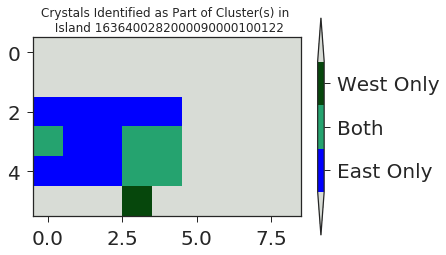

Unique island:  1636400282000090000100117 (entry 4250 )
     KS Result:  0.9793631144957665
Unique island:  1636400282000090000100110 (entry 4251 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090000100115 (entry 4252 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000090000100118 (entry 4253 )
     KS Result:  0.9780359353565411
Unique island:  1636400282000090000100123 (entry 4254 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000090000100120 (entry 4255 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000090000100114 (entry 4256 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000090000100119 (entry 4257 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000090000100130 (entry 4258 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090000100121 (entry 4259 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000090000100113 (entry 4260 )
     KS Result:  0.48195

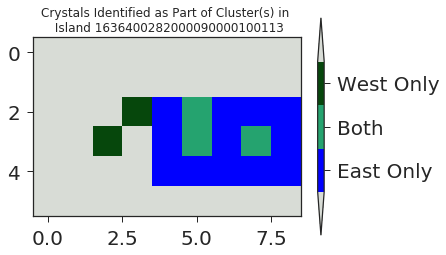

Unique island:  1636400282000090000100128 (entry 4261 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000090000100124 (entry 4262 )
     KS Result:  0.9999441982429496
Unique island:  1636400282000090000100116 (entry 4263 )
     KS Result:  0.8079241602959086
Unique island:  1636400282000090000100129 (entry 4264 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000090000100126 (entry 4265 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000090000100125 (entry 4266 )
     KS Result:  0.994241144886877
Unique island:  1636400282000090000100131 (entry 4267 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000090000100134 (entry 4268 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000090000100132 (entry 4269 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000090000100133 (entry 4270 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000090000100136 (entry 4271 )
     KS Result:  1.0
Uniq

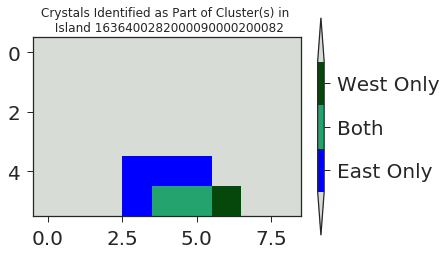

Unique island:  1636400282000090000200075 (entry 4356 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090000200085 (entry 4357 )
     KS Result:  0.8474884542294501
Unique island:  1636400282000090000200086 (entry 4358 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000090000200090 (entry 4359 )
     KS Result:  0.9513037360389418
Unique island:  1636400282000090000200094 (entry 4360 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000090000200093 (entry 4361 )
     KS Result:  0.998265735388435
Unique island:  1636400282000090000200092 (entry 4362 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000090000200091 (entry 4363 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090000200095 (entry 4364 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000090000200096 (entry 4365 )
     KS Result:  0.7357765101578164
Unique island:  1636400282000090000200097 (entry 4366 )
     KS Result:  0.988261

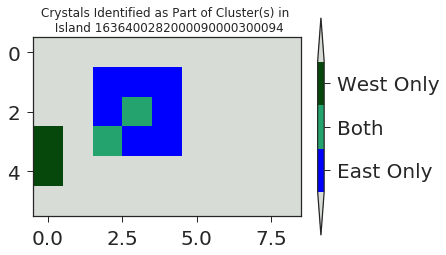

Unique island:  1636400282000090000300084 (entry 4466 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090000300103 (entry 4467 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000090000300098 (entry 4468 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000090000300099 (entry 4469 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090000300082 (entry 4470 )
     KS Result:  0.994241144886877
Unique island:  1636400282000090000300088 (entry 4471 )
     KS Result:  0.994241144886877
Unique island:  1636400282000090000300090 (entry 4472 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000090000300085 (entry 4473 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000090000300101 (entry 4474 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000090000300106 (entry 4475 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000090000300100 (entry 4476 )
     KS Result:  0.9882610

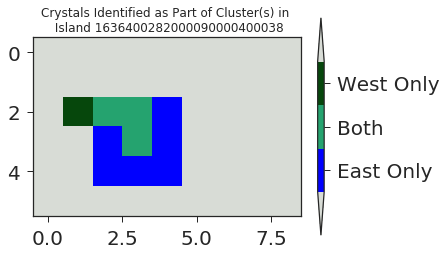

Unique island:  1636400282000090000400049 (entry 4542 )
     KS Result:  0.920740593169981
Unique island:  1636400282000090000400035 (entry 4544 )
     KS Result:  0.998265735388435
Unique island:  1636400282000090000400054 (entry 4545 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000090000400060 (entry 4546 )
     KS Result:  0.8186211748061036
Unique island:  1636400282000090000400052 (entry 4548 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000090000400030 (entry 4549 )
     KS Result:  0.994241144886877
Unique island:  1636400282000090000400039 (entry 4550 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000090000400024 (entry 4551 )
     KS Result:  0.8927783374482007
Unique island:  1636400282000090000400029 (entry 4552 )
     KS Result:  0.9919638849816804
Unique island:  1636400282000090000400062 (entry 4553 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000090000400042 (entry 4554 )
     KS Result:  0.97936311

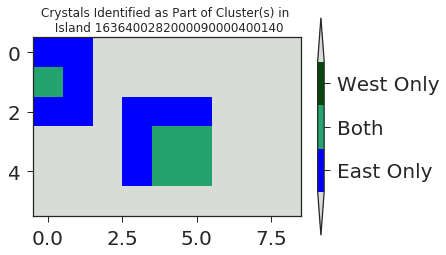

Unique island:  1636400282000090000400122 (entry 4616 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000090000400118 (entry 4617 )
     KS Result:  0.994241144886877
Unique island:  1636400282000090000400121 (entry 4618 )
     KS Result:  0.8855519111836548
Unique island:  1636400282000090000400119 (entry 4619 )
     KS Result:  0.765763173908239
Unique island:  1636400282000090000400124 (entry 4620 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000090000400128 (entry 4621 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090000400125 (entry 4622 )
     KS Result:  0.9919638849816804
Unique island:  1636400282000090000400129 (entry 4623 )
     KS Result:  0.5493264419710108


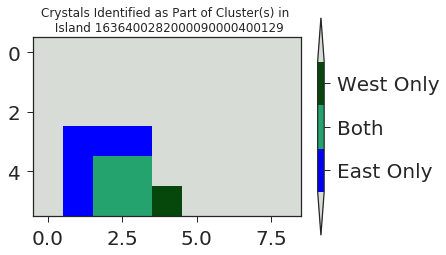

Unique island:  1636400282000090000400127 (entry 4624 )
     KS Result:  0.9919638849816804
Unique island:  1636400282000090000400143 (entry 4625 )
     KS Result:  0.9999605599346801
Unique island:  1636400282000090000400133 (entry 4627 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090000400126 (entry 4628 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000090000400130 (entry 4629 )
     KS Result:  0.5296714468087738


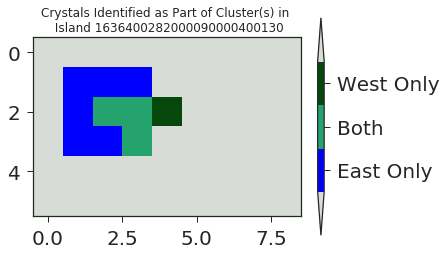

Unique island:  1636400282000090000400134 (entry 4630 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000090000400131 (entry 4631 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000090000400132 (entry 4632 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090000400136 (entry 4633 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000090000400137 (entry 4634 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000090000400139 (entry 4635 )
     KS Result:  0.9780359353565409
Unique island:  1636400282000090000400138 (entry 4636 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000090000400142 (entry 4637 )
     KS Result:  0.994241144886877
Unique island:  1636400282000090000400144 (entry 4638 )
     KS Result:  0.9999441982429496
Unique island:  1636400282000090000400145 (entry 4639 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000090000400147 (entry 4640 )
     KS Result:  0.972543

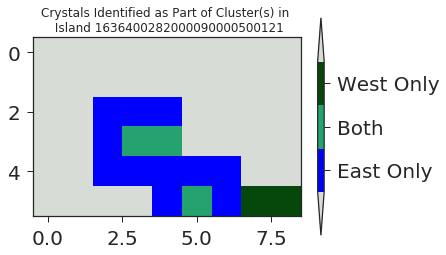

Unique island:  1636400282000090000500091 (entry 4709 )
     KS Result:  0.998265735388435
Unique island:  1636400282000090000500106 (entry 4710 )
     KS Result:  0.998265735388435
Unique island:  1636400282000090000500107 (entry 4711 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000090000500089 (entry 4712 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000090000500094 (entry 4713 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000090000500098 (entry 4714 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000090000500097 (entry 4715 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000090000500104 (entry 4716 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000090000500092 (entry 4717 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000090000500108 (entry 4718 )
     KS Result:  0.6464668052400346
Unique island:  1636400282000090000500103 (entry 4720 )
     KS Result:  0.9982657

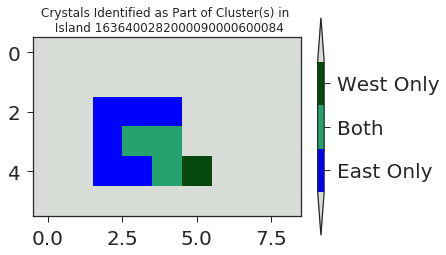

Unique island:  1636400282000090000600085 (entry 4822 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000090000600083 (entry 4823 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000090000600086 (entry 4824 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000090000600080 (entry 4825 )
     KS Result:  0.994241144886877
Unique island:  1636400282000090000600087 (entry 4826 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000090000600098 (entry 4827 )
     KS Result:  0.6993741996864224
Unique island:  1636400282000090000600092 (entry 4829 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000090000600089 (entry 4830 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000090000600091 (entry 4831 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000090000600090 (entry 4832 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000090000600088 (entry 4833 )
     KS Result:  0.956964

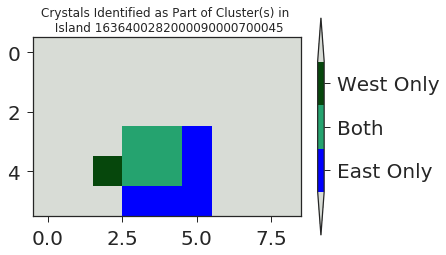

Unique island:  1636400282000090000700042 (entry 4882 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090000700037 (entry 4883 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000090000700019 (entry 4884 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000090000700036 (entry 4885 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000090000700087 (entry 4886 )
     KS Result:  0.9999999998919139
Unique island:  1636400282000090000700056 (entry 4888 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000090000700035 (entry 4889 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000090000700032 (entry 4890 )
     KS Result:  0.9999441982429496
Unique island:  1636400282000090000700054 (entry 4891 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000090000700025 (entry 4892 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000090000700057 (entry 4893 )
     KS Result:  0.93244

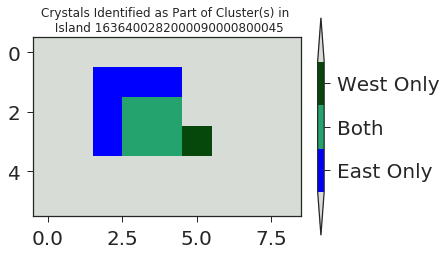

Unique island:  1636400282000090000800064 (entry 5037 )
     KS Result:  0.9999999542351722
Unique island:  1636400282000090000800035 (entry 5039 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090000800020 (entry 5040 )
     KS Result:  0.634989481197492
Unique island:  1636400282000090000800054 (entry 5041 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000090000800032 (entry 5042 )
     KS Result:  0.994241144886877
Unique island:  1636400282000090000800042 (entry 5043 )
     KS Result:  0.9793631144957665
Unique island:  1636400282000090000800040 (entry 5044 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000090000800026 (entry 5045 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000090000800014 (entry 5046 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000090000800041 (entry 5047 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000090000800038 (entry 5048 )
     KS Result:  0.9639452

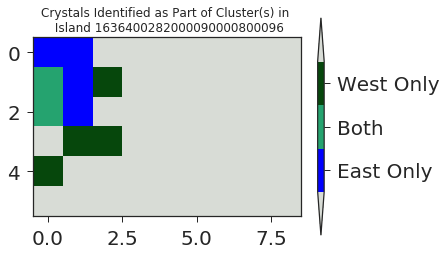

Unique island:  1636400282000090000800099 (entry 5064 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000090000800087 (entry 5065 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000090000800077 (entry 5066 )
     KS Result:  0.6993741996864222
Unique island:  1636400282000090000800100 (entry 5067 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000090000800083 (entry 5068 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000090000800094 (entry 5069 )
     KS Result:  0.998265735388435
Unique island:  1636400282000090000800079 (entry 5070 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000090000800102 (entry 5071 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000090000800092 (entry 5072 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000090000800093 (entry 5073 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000090000800078 (entry 5074 )
     KS Result:  0.999984

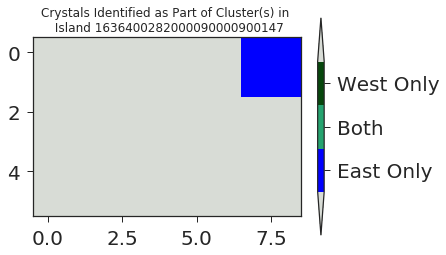

Unique island:  1636400282000090001000039 (entry 5245 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000090001000049 (entry 5246 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000090001000012 (entry 5247 )
     KS Result:  0.9882610776652121
Unique island:  1636400282000090001000056 (entry 5248 )
     KS Result:  0.998265735388435
Unique island:  1636400282000090001000031 (entry 5249 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090001000047 (entry 5250 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000090001000032 (entry 5251 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090001000014 (entry 5252 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000090001000024 (entry 5253 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000090001000050 (entry 5254 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000090001000027 (entry 5255 )
     KS Result:  0.918018

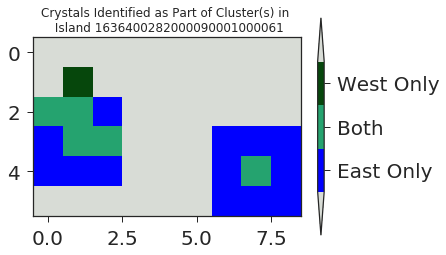

Unique island:  1636400282000090001000045 (entry 5265 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000090001000051 (entry 5266 )
     KS Result:  0.8402484746377933
Unique island:  1636400282000090001000019 (entry 5267 )
     KS Result:  0.994241144886877
Unique island:  1636400282000090001000035 (entry 5268 )
     KS Result:  0.6870911965696748
Unique island:  1636400282000090001000026 (entry 5269 )
     KS Result:  0.994241144886877
Unique island:  1636400282000090001000036 (entry 5270 )
     KS Result:  0.6870911965696748
Unique island:  1636400282000090001000043 (entry 5271 )
     KS Result:  0.9439727178931837
Unique island:  1636400282000090001000041 (entry 5273 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000090001000028 (entry 5274 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000090001000048 (entry 5275 )
     KS Result:  0.9906895533940197
Unique island:  1636400282000090001000053 (entry 5276 )
     KS Result:  0.5041206

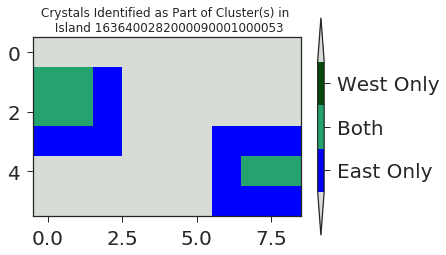

Unique island:  1636400282000090001000037 (entry 5278 )
     KS Result:  0.765763173908239
Unique island:  1636400282000090001000059 (entry 5279 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090001000038 (entry 5280 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000090001000040 (entry 5281 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000090001000042 (entry 5282 )
     KS Result:  0.7783641848212086
Unique island:  1636400282000090001000060 (entry 5284 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000090001000064 (entry 5285 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000090001000065 (entry 5286 )
     KS Result:  0.998265735388435
Unique island:  1636400282000090001000127 (entry 5287 )
     KS Result:  0.998265735388435
Unique island:  1636400282000090001000075 (entry 5291 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000090001000073 (entry 5292 )
     KS Result:  0.91801842

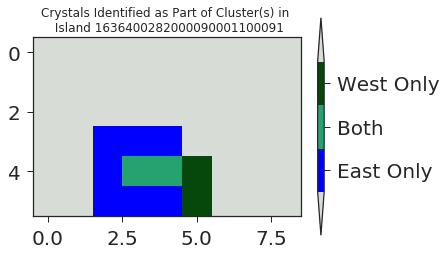

Unique island:  1636400282000090001100095 (entry 5433 )
     KS Result:  0.998265735388435
Unique island:  1636400282000090001100092 (entry 5434 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000090001100097 (entry 5435 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000090001100108 (entry 5436 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090001100098 (entry 5437 )
     KS Result:  0.9919638849816804
Unique island:  1636400282000090001100107 (entry 5438 )
     KS Result:  0.5493264419710108


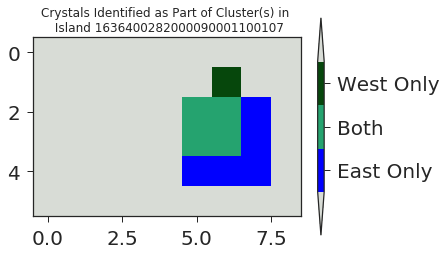

Unique island:  1636400282000090001100105 (entry 5439 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090001100106 (entry 5440 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090001100100 (entry 5441 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000090001100099 (entry 5442 )
     KS Result:  0.994241144886877
Unique island:  1636400282000090001100104 (entry 5443 )
     KS Result:  0.998265735388435
Unique island:  1636400282000090001100103 (entry 5444 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000090001100102 (entry 5445 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000090001100101 (entry 5446 )
     KS Result:  0.9513037360389418
Unique island:  1636400282000090001100110 (entry 5447 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000090001100109 (entry 5448 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090001100111 (entry 5449 )
     KS Result:  0.9180184

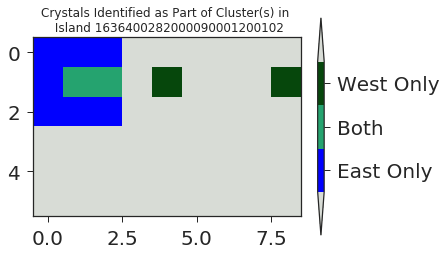

Unique island:  1636400282000090001200114 (entry 5583 )
     KS Result:  0.9999999955914529
Unique island:  1636400282000090001200106 (entry 5584 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000090001200112 (entry 5585 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000090001200118 (entry 5586 )
     KS Result:  0.9408422664059389
Unique island:  1636400282000090001200108 (entry 5588 )
     KS Result:  0.9999999999356389
Unique island:  1636400282000090001200119 (entry 5589 )
     KS Result:  0.9513037360389418
Unique island:  1636400282000090001200115 (entry 5590 )
     KS Result:  0.9852795287266235
Unique island:  1636400282000090001200123 (entry 5592 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000090001200122 (entry 5593 )
     KS Result:  0.7989513620291605
Unique island:  1636400282000090001200120 (entry 5594 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000090001200116 (entry 5595 )
     KS Result:  0.90300

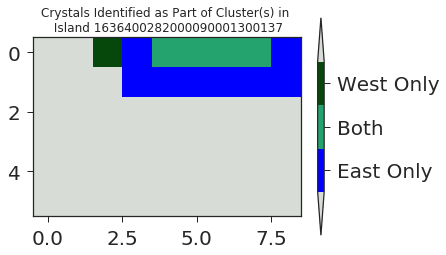

Unique island:  1636400282000090001300132 (entry 5743 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000090001300139 (entry 5744 )
     KS Result:  0.8402484746377933
Unique island:  1636400282000090001300134 (entry 5745 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000090001300138 (entry 5746 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000090001300136 (entry 5747 )
     KS Result:  0.5296714468087738


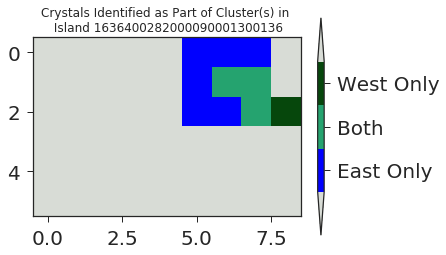

Unique island:  1636400282000090001300141 (entry 5748 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000090001300142 (entry 5749 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000090001300140 (entry 5750 )
     KS Result:  0.765763173908239
Unique island:  1636400282000090001300143 (entry 5751 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090001300145 (entry 5752 )
     KS Result:  1.0
Unique island:  1636400282000090001300146 (entry 5753 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000090001300144 (entry 5755 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000090001300147 (entry 5756 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000090001300149 (entry 5757 )
     KS Result:  0.9725430381908993
Unique island:  1636400282000090001300148 (entry 5758 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000090001300150 (entry 5759 )
     KS Result:  0.9324454652858934
Uniq

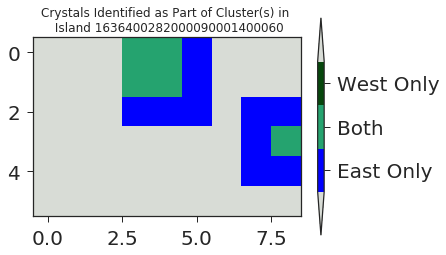

Unique island:  1636400282000090001400022 (entry 5793 )
     KS Result:  0.8781816046495936
Unique island:  1636400282000090001400049 (entry 5795 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000090001400023 (entry 5796 )
     KS Result:  0.9919638849816804
Unique island:  1636400282000090001400024 (entry 5797 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000090001400042 (entry 5798 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000090001400032 (entry 5799 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000090001400020 (entry 5800 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000090001400034 (entry 5801 )
     KS Result:  0.8855519111836548
Unique island:  1636400282000090001400026 (entry 5802 )
     KS Result:  0.8474884542294501
Unique island:  1636400282000090001400019 (entry 5803 )
     KS Result:  0.6870911965696748
Unique island:  1636400282000090001400037 (entry 5804 )
     KS Result:  0.76576

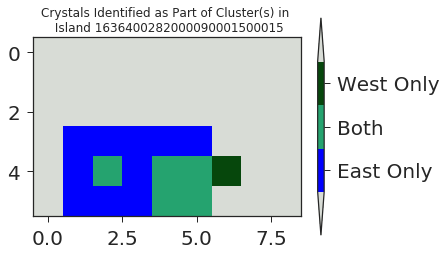

Unique island:  1636400282000090001500020 (entry 5907 )
     KS Result:  0.9919638849816804
Unique island:  1636400282000090001500061 (entry 5908 )
     KS Result:  0.6748939772456368
Unique island:  1636400282000090001500034 (entry 5910 )
     KS Result:  0.9999441982429496
Unique island:  1636400282000090001500027 (entry 5911 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000090001500013 (entry 5912 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090001500016 (entry 5913 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000090001500028 (entry 5914 )
     KS Result:  0.9793631144957665
Unique island:  1636400282000090001500008 (entry 5915 )
     KS Result:  0.8588498786512344
Unique island:  1636400282000090001500002 (entry 5916 )
     KS Result:  0.994241144886877
Unique island:  1636400282000090001500024 (entry 5917 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000090001500046 (entry 5918 )
     KS Result:  0.979363

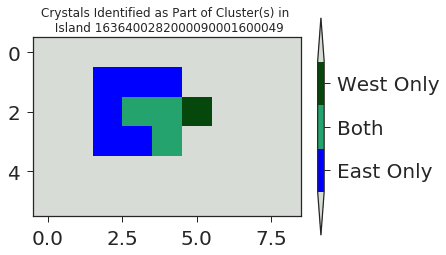

Unique island:  1636400282000090001600056 (entry 6084 )
     KS Result:  0.705669446523443
Unique island:  1636400282000090001600057 (entry 6086 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090001600060 (entry 6087 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000090001600071 (entry 6088 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000090001600059 (entry 6089 )
     KS Result:  0.7989513620291605
Unique island:  1636400282000090001600103 (entry 6091 )
     KS Result:  0.8583602534264955
Unique island:  1636400282000090001600068 (entry 6093 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000090001600084 (entry 6094 )
     KS Result:  0.9513037360389418
Unique island:  1636400282000090001600062 (entry 6095 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000090001600066 (entry 6096 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000090001600061 (entry 6097 )
     KS Result:  0.874248

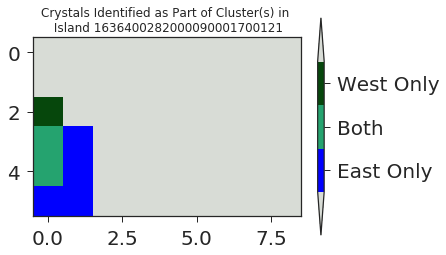

Unique island:  1636400282000090001700119 (entry 6271 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000090001700118 (entry 6272 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000090001700122 (entry 6273 )
     KS Result:  0.9793631144957665
Unique island:  1636400282000090001700117 (entry 6274 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090001700123 (entry 6275 )
     KS Result:  0.9780359353565411
Unique island:  1636400282000090001700125 (entry 6276 )
     KS Result:  0.5493264419710108


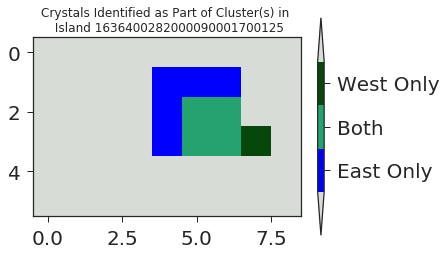

Unique island:  1636400282000090001700124 (entry 6277 )
     KS Result:  0.998265735388435
Unique island:  1636400282000090001700127 (entry 6278 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000090001700126 (entry 6279 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000090001800007 (entry 6280 )
     KS Result:  0.9793631144957665
Unique island:  1636400282000090001800015 (entry 6281 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000090001800031 (entry 6282 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000090001800021 (entry 6283 )
     KS Result:  0.8402484746377933
Unique island:  1636400282000090001800011 (entry 6284 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000090001800067 (entry 6285 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000090001800026 (entry 6286 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090001800059 (entry 6287 )
     KS Result:  0.918018

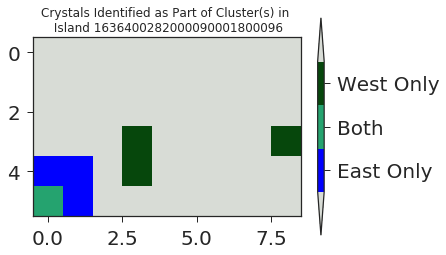

Unique island:  1636400282000090001800112 (entry 6369 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000090001800105 (entry 6370 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000090001800113 (entry 6371 )
     KS Result:  0.998265735388435
Unique island:  1636400282000090001800108 (entry 6372 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090001800111 (entry 6373 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000090001800106 (entry 6374 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090001800116 (entry 6375 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000090001800114 (entry 6376 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090001800118 (entry 6377 )
     KS Result:  0.8781816046495938
Unique island:  1636400282000090001800119 (entry 6378 )
     KS Result:  0.8855519111836548
Unique island:  1636400282000090001800115 (entry 6379 )
     KS Result:  0.932445

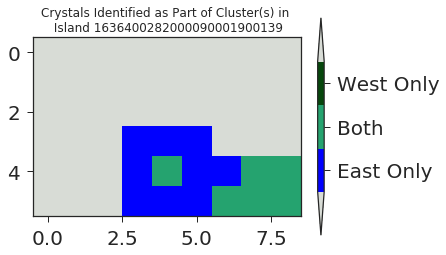

Unique island:  1636400282000090001900136 (entry 6530 )
     KS Result:  0.994241144886877
Unique island:  1636400282000090001900140 (entry 6531 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000090001900141 (entry 6532 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000090001900142 (entry 6533 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000090002000045 (entry 6534 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000090002000038 (entry 6535 )
     KS Result:  0.978035935356541
Unique island:  1636400282000090002000059 (entry 6536 )
     KS Result:  0.6944514619376467
Unique island:  1636400282000090002000024 (entry 6538 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000090002000032 (entry 6539 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000090002000044 (entry 6540 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000090002000015 (entry 6541 )
     KS Result:  0.0


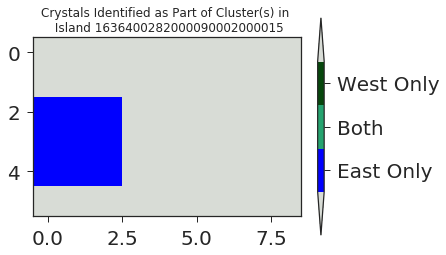

Unique island:  1636400282000090002000042 (entry 6542 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090002000037 (entry 6543 )
     KS Result:  0.994241144886877
Unique island:  1636400282000090002000041 (entry 6544 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000090002000072 (entry 6545 )
     KS Result:  0.978217395628216
Unique island:  1636400282000090002000035 (entry 6548 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000090002000033 (entry 6549 )
     KS Result:  0.9513037360389418
Unique island:  1636400282000090002000039 (entry 6550 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000090002000053 (entry 6551 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000090002000029 (entry 6552 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000090002000017 (entry 6553 )
     KS Result:  0.994241144886877
Unique island:  1636400282000090002000061 (entry 6554 )
     KS Result:  0.99068955

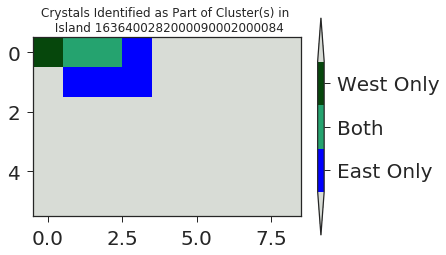

Unique island:  1636400282000090002000095 (entry 6604 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000090002000088 (entry 6605 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000090002000094 (entry 6606 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000090002000076 (entry 6607 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000090002000087 (entry 6608 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000090002000080 (entry 6609 )
     KS Result:  0.6476207862301019
Unique island:  1636400282000090002000090 (entry 6611 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000090002000092 (entry 6612 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000090002000081 (entry 6613 )
     KS Result:  0.759097838865462
Unique island:  1636400282000090002000100 (entry 6614 )
     KS Result:  0.999965230654072
Unique island:  1636400282000090002000098 (entry 6615 )
     KS Result:  0.9180184

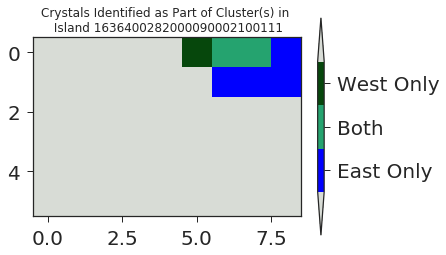

Unique island:  1636400282000090002100107 (entry 6760 )
     KS Result:  0.8402484746377933
Unique island:  1636400282000090002100096 (entry 6761 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000090002100105 (entry 6762 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000090002100108 (entry 6763 )
     KS Result:  0.8927783374482007
Unique island:  1636400282000090002100112 (entry 6765 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090002100113 (entry 6766 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000090002100114 (entry 6767 )
     KS Result:  0.9513037360389418
Unique island:  1636400282000090002100117 (entry 6768 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000090002100115 (entry 6769 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000090002100118 (entry 6770 )
     KS Result:  0.8855519111836548
Unique island:  1636400282000090002100116 (entry 6771 )
     KS Result:  0.91801

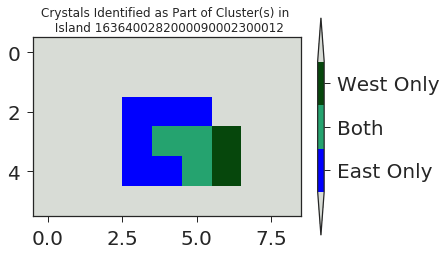

Unique island:  1636400282000090002300028 (entry 6970 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000090002300057 (entry 6971 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000090002300052 (entry 6972 )
     KS Result:  0.998265735388435
Unique island:  1636400282000090002300056 (entry 6973 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000090002300044 (entry 6974 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000090002300069 (entry 6975 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000090002300067 (entry 6976 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000090002300076 (entry 6977 )
     KS Result:  0.9999967699558283
Unique island:  1636400282000090002300072 (entry 6978 )
     KS Result:  0.994241144886877
Unique island:  1636400282000090002300070 (entry 6979 )
     KS Result:  0.998265735388435
Unique island:  1636400282000090002300112 (entry 6980 )
     KS Result:  0.69000837

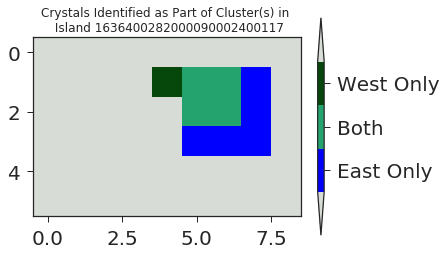

Unique island:  1636400282000090002400104 (entry 7134 )
     KS Result:  0.998265735388435
Unique island:  1636400282000090002400099 (entry 7135 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000090002400106 (entry 7136 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000090002400103 (entry 7137 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000090002400113 (entry 7138 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000090002400110 (entry 7139 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090002400123 (entry 7140 )
     KS Result:  0.9995243721606145
Unique island:  1636400282000090002400118 (entry 7141 )
     KS Result:  0.9999441982429496
Unique island:  1636400282000090002400127 (entry 7142 )
     KS Result:  0.9638144860954309
Unique island:  1636400282000090002400116 (entry 7143 )
     KS Result:  0.6870911965696748
Unique island:  1636400282000090002400120 (entry 7144 )
     KS Result:  0.979363

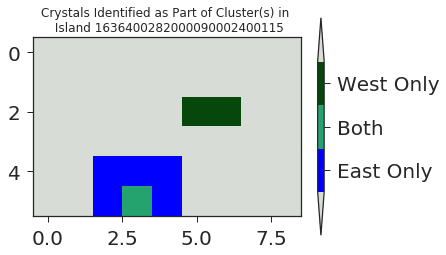

Unique island:  1636400282000090002400126 (entry 7147 )
     KS Result:  0.9999913128204173
Unique island:  1636400282000090002400124 (entry 7148 )
     KS Result:  0.999965230654072
Unique island:  1636400282000090002400128 (entry 7149 )
     KS Result:  0.9999441982429496
Unique island:  1636400282000090002400122 (entry 7150 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000090002400125 (entry 7151 )
     KS Result:  0.8781816046495938
Unique island:  1636400282000090002400129 (entry 7152 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000090002400130 (entry 7153 )
     KS Result:  0.9513037360389418
Unique island:  1636400282000090002400132 (entry 7154 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000090002400135 (entry 7155 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000090002400133 (entry 7156 )
     KS Result:  0.8474884542294501
Unique island:  1636400282000090002400136 (entry 7157 )
     KS Result:  0.999633

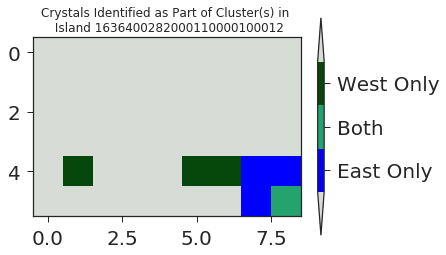

Unique island:  1636400282000110000100055 (entry 7215 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000110000100029 (entry 7216 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000110000100021 (entry 7217 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000110000100048 (entry 7218 )
     KS Result:  0.8674258676307465
Unique island:  1636400282000110000100039 (entry 7219 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000110000100034 (entry 7220 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000110000100027 (entry 7221 )
     KS Result:  0.8855519111836548
Unique island:  1636400282000110000100053 (entry 7222 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110000100040 (entry 7223 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110000100058 (entry 7224 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000110000100052 (entry 7225 )
     KS Result:  0.91801

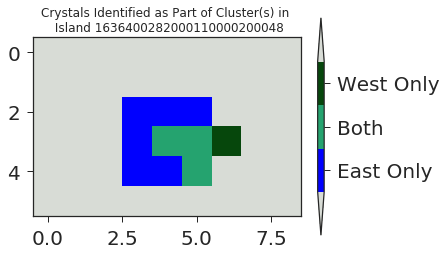

Unique island:  1636400282000110000200066 (entry 7342 )
     KS Result:  0.6944514619376467
Unique island:  1636400282000110000200003 (entry 7344 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000110000200038 (entry 7345 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000110000200035 (entry 7346 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000110000200057 (entry 7347 )
     KS Result:  0.6870911965696748
Unique island:  1636400282000110000200056 (entry 7348 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000110000200049 (entry 7349 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000110000200039 (entry 7350 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000110000200024 (entry 7351 )
     KS Result:  0.765763173908239
Unique island:  1636400282000110000200046 (entry 7352 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000110000200054 (entry 7353 )
     KS Result:  0.963945

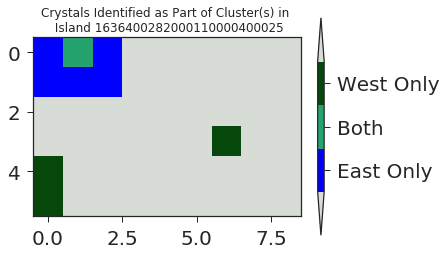

Unique island:  1636400282000110000400070 (entry 7595 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000110000400059 (entry 7596 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000110000400080 (entry 7597 )
     KS Result:  0.8927783374482007
Unique island:  1636400282000110000400033 (entry 7599 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110000400045 (entry 7600 )
     KS Result:  0.9919638849816804
Unique island:  1636400282000110000400078 (entry 7601 )
     KS Result:  0.9992134403619041
Unique island:  1636400282000110000400051 (entry 7603 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000110000400056 (entry 7604 )
     KS Result:  0.994241144886877
Unique island:  1636400282000110000400048 (entry 7605 )
     KS Result:  0.994241144886877
Unique island:  1636400282000110000400082 (entry 7606 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000110000400083 (entry 7607 )
     KS Result:  0.7657631

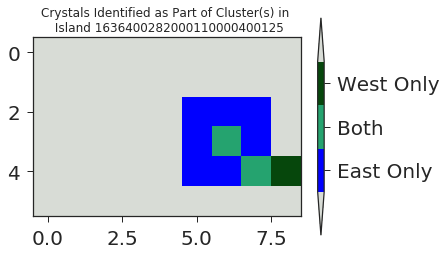

Unique island:  1636400282000110000400129 (entry 7649 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000110000400127 (entry 7650 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000110000400130 (entry 7651 )
     KS Result:  0.9999441982429496
Unique island:  1636400282000110000400133 (entry 7652 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000110000400131 (entry 7653 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000110000400134 (entry 7654 )
     KS Result:  0.9999999999356389
Unique island:  1636400282000110000400137 (entry 7655 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000110000400155 (entry 7656 )
     KS Result:  0.9771244324992944
Unique island:  1636400282000110000400135 (entry 7658 )
     KS Result:  0.796412508578516
Unique island:  1636400282000110000400132 (entry 7659 )
     KS Result:  0.736471209965501
Unique island:  1636400282000110000400141 (entry 7660 )
     KS Result:  0.9999999

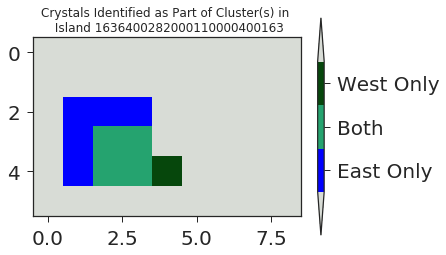

Unique island:  1636400282000110000400164 (entry 7687 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110000500032 (entry 7688 )
     KS Result:  0.9954646531479324
Unique island:  1636400282000110000500051 (entry 7690 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000110000500058 (entry 7691 )
     KS Result:  0.9919638849816804
Unique island:  1636400282000110000500045 (entry 7692 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000110000500059 (entry 7693 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000110000500047 (entry 7694 )
     KS Result:  0.7277035592820812
Unique island:  1636400282000110000500042 (entry 7696 )
     KS Result:  0.8855519111836548
Unique island:  1636400282000110000500063 (entry 7697 )
     KS Result:  0.9513037360389418
Unique island:  1636400282000110000500043 (entry 7698 )
     KS Result:  0.9616646749184734
Unique island:  1636400282000110000500040 (entry 7700 )
     KS Result:  0.87818

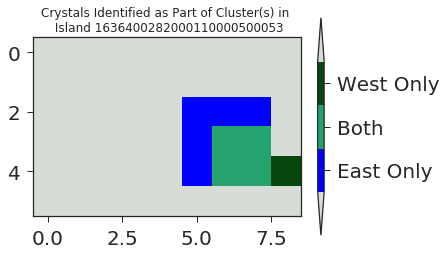

Unique island:  1636400282000110000500027 (entry 7720 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000110000500019 (entry 7721 )
     KS Result:  0.9882610776652121
Unique island:  1636400282000110000500066 (entry 7722 )
     KS Result:  0.998265735388435
Unique island:  1636400282000110000500026 (entry 7723 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000110000500049 (entry 7724 )
     KS Result:  0.9999441982429496
Unique island:  1636400282000110000500054 (entry 7725 )
     KS Result:  0.9919638849816804
Unique island:  1636400282000110000500044 (entry 7726 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000110000500057 (entry 7727 )
     KS Result:  0.4755937630041422


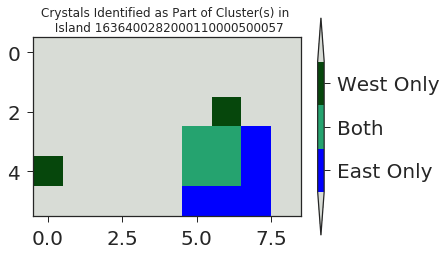

Unique island:  1636400282000110000500033 (entry 7728 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110000500030 (entry 7729 )
     KS Result:  0.9793631144957665
Unique island:  1636400282000110000500052 (entry 7730 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000110000500067 (entry 7731 )
     KS Result:  0.8402484746377933
Unique island:  1636400282000110000500068 (entry 7732 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110000500061 (entry 7733 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000110000500056 (entry 7734 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000110000500065 (entry 7735 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000110000500076 (entry 7736 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110000500075 (entry 7737 )
     KS Result:  0.9639452437314863
Unique island:  1636400282000110000500079 (entry 7738 )
     KS Result:  0.99480

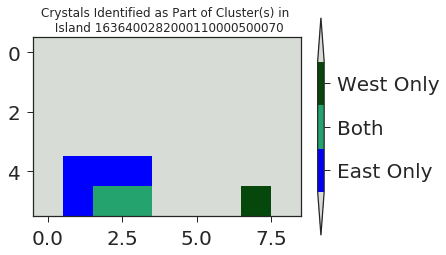

Unique island:  1636400282000110000500071 (entry 7740 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000110000500072 (entry 7741 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000110000500086 (entry 7742 )
     KS Result:  0.765763173908239
Unique island:  1636400282000110000500080 (entry 7743 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000110000500077 (entry 7744 )
     KS Result:  0.998265735388435
Unique island:  1636400282000110000500074 (entry 7745 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000110000500084 (entry 7746 )
     KS Result:  0.8855519111836548
Unique island:  1636400282000110000500078 (entry 7747 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000110000500073 (entry 7748 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000110000500083 (entry 7749 )
     KS Result:  0.9882610776652121
Unique island:  1636400282000110000500087 (entry 7750 )
     KS Result:  0.6870911

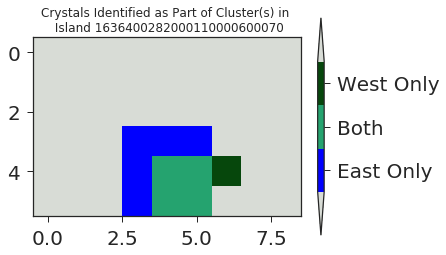

Unique island:  1636400282000110000600078 (entry 7831 )
     KS Result:  0.998265735388435
Unique island:  1636400282000110000600067 (entry 7832 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110000600095 (entry 7833 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000110000600075 (entry 7834 )
     KS Result:  0.8781816046495938
Unique island:  1636400282000110000600086 (entry 7835 )
     KS Result:  0.8884604030744512
Unique island:  1636400282000110000600074 (entry 7837 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000110000600089 (entry 7838 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110000600083 (entry 7839 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110000600098 (entry 7840 )
     KS Result:  0.9999999955914529
Unique island:  1636400282000110000600084 (entry 7841 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000110000600081 (entry 7842 )
     KS Result:  0.994801

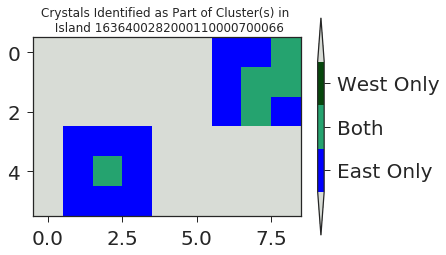

Unique island:  1636400282000110000700019 (entry 7921 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000110000700017 (entry 7922 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000110000700054 (entry 7923 )
     KS Result:  0.6870911965696748
Unique island:  1636400282000110000700042 (entry 7924 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000110000700043 (entry 7925 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000110000700053 (entry 7926 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000110000700021 (entry 7927 )
     KS Result:  0.9919638849816804
Unique island:  1636400282000110000700030 (entry 7928 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000110000700051 (entry 7929 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110000700057 (entry 7930 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000110000700052 (entry 7931 )
     KS Result:  0.88555

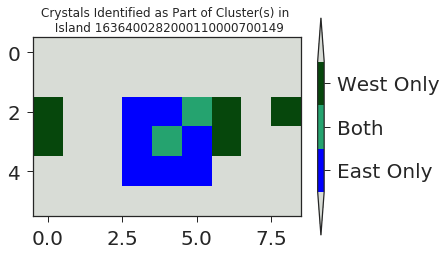

Unique island:  1636400282000110000700151 (entry 8017 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000110000700150 (entry 8018 )
     KS Result:  0.9999441982429496
Unique island:  1636400282000110000700152 (entry 8019 )
     KS Result:  0.765763173908239
Unique island:  1636400282000110000700153 (entry 8020 )
     KS Result:  0.9248877561860762
Unique island:  1636400282000110000800072 (entry 8022 )
     KS Result:  0.9539091125510804
Unique island:  1636400282000110000800038 (entry 8024 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000110000800061 (entry 8025 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000110000800060 (entry 8026 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000110000800047 (entry 8027 )
     KS Result:  0.976258913295221
Unique island:  1636400282000110000800029 (entry 8028 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000110000800032 (entry 8029 )
     KS Result:  0.9324454

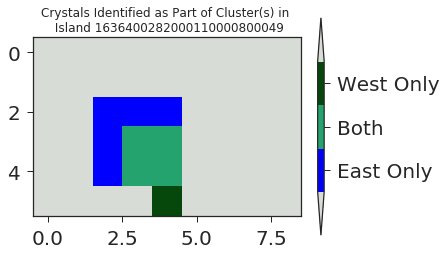

Unique island:  1636400282000110000800065 (entry 8047 )
     KS Result:  0.998265735388435
Unique island:  1636400282000110000800048 (entry 8048 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110000800064 (entry 8049 )
     KS Result:  0.998265735388435
Unique island:  1636400282000110000800079 (entry 8050 )
     KS Result:  0.9995243721606145
Unique island:  1636400282000110000800042 (entry 8051 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000110000800053 (entry 8052 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110000800044 (entry 8053 )
     KS Result:  0.9793631144957665
Unique island:  1636400282000110000800025 (entry 8054 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000110000800043 (entry 8055 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110000800034 (entry 8056 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000110000800024 (entry 8057 )
     KS Result:  0.7657631

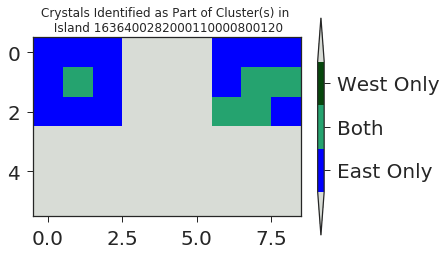

Unique island:  1636400282000110000800122 (entry 8112 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000110000800121 (entry 8113 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000110000800129 (entry 8114 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000110000800126 (entry 8115 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000110000800125 (entry 8116 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000110000800128 (entry 8117 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000110000800130 (entry 8118 )
     KS Result:  0.998265735388435
Unique island:  1636400282000110000800131 (entry 8119 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000110000800127 (entry 8120 )
     KS Result:  0.765763173908239
Unique island:  1636400282000110000800133 (entry 8121 )
     KS Result:  0.9999992291718
Unique island:  1636400282000110000800137 (entry 8122 )
     KS Result:  0.6870911965

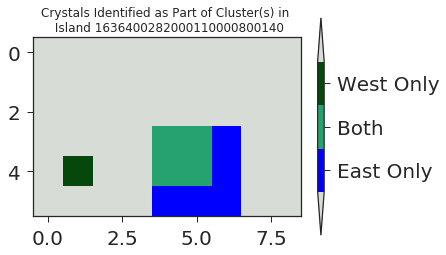

Unique island:  1636400282000110000800145 (entry 8131 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000110000800142 (entry 8132 )
     KS Result:  0.8855519111836548
Unique island:  1636400282000110000800144 (entry 8133 )
     KS Result:  0.9793631144957665
Unique island:  1636400282000110000800136 (entry 8134 )
     KS Result:  0.9793631144957665
Unique island:  1636400282000110000800143 (entry 8135 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000110000800146 (entry 8136 )
     KS Result:  0.9882610776652121
Unique island:  1636400282000110000800148 (entry 8137 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000110000800147 (entry 8138 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000110000800149 (entry 8139 )
     KS Result:  0.9639452437314862
Unique island:  1636400282000110000800150 (entry 8140 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000110000800151 (entry 8141 )
     KS Result:  0.88555

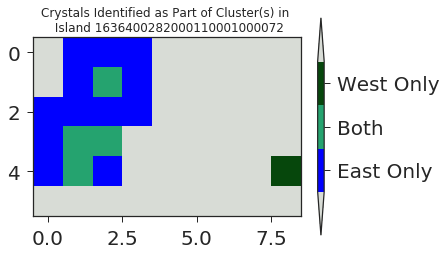

Unique island:  1636400282000110001000053 (entry 8246 )
     KS Result:  0.9180184255186957
Unique island:  1636400282000110001000021 (entry 8247 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000110001000087 (entry 8248 )
     KS Result:  0.9671126526243201
Unique island:  1636400282000110001000023 (entry 8250 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000110001000032 (entry 8251 )
     KS Result:  0.9950665063958158
Unique island:  1636400282000110001000014 (entry 8252 )
     KS Result:  0.994241144886877
Unique island:  1636400282000110001000061 (entry 8253 )
     KS Result:  0.976258913295221
Unique island:  1636400282000110001000041 (entry 8255 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000110001000069 (entry 8256 )
     KS Result:  0.9868227984173786
Unique island:  1636400282000110001000040 (entry 8258 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110001000055 (entry 8259 )
     KS Result:  0.9999441

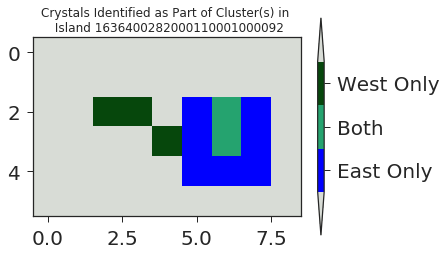

Unique island:  1636400282000110001000110 (entry 8330 )
     KS Result:  0.994241144886877
Unique island:  1636400282000110001000108 (entry 8331 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000110001000107 (entry 8332 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000110001000101 (entry 8333 )
     KS Result:  0.765763173908239
Unique island:  1636400282000110001000117 (entry 8334 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000110001000111 (entry 8336 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000110001000114 (entry 8337 )
     KS Result:  0.9999999955914529
Unique island:  1636400282000110001000113 (entry 8338 )
     KS Result:  0.994241144886877
Unique island:  1636400282000110001000115 (entry 8339 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000110001000116 (entry 8340 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000110001000118 (entry 8341 )
     KS Result:  0.90300836

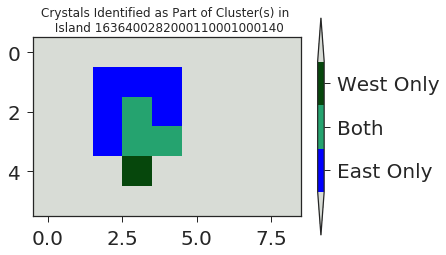

Unique island:  1636400282000110001000142 (entry 8366 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110001000139 (entry 8367 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000110001000138 (entry 8368 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110001000144 (entry 8369 )
     KS Result:  0.998265735388435
Unique island:  1636400282000110001000145 (entry 8370 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000110001000146 (entry 8371 )
     KS Result:  0.978035935356541
Unique island:  1636400282000110001000147 (entry 8372 )
     KS Result:  0.999965230654072
Unique island:  1636400282000110001000149 (entry 8373 )
     KS Result:  0.9513037360389418
Unique island:  1636400282000110001000150 (entry 8374 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000110001000152 (entry 8375 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000110001000151 (entry 8376 )
     KS Result:  0.90300836

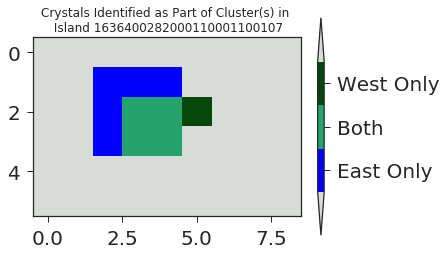

Unique island:  1636400282000110001100092 (entry 8456 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000110001100095 (entry 8457 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110001100090 (entry 8458 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000110001100098 (entry 8459 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000110001100100 (entry 8460 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000110001100103 (entry 8461 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110001100093 (entry 8462 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000110001100112 (entry 8463 )
     KS Result:  0.9180184255186957
Unique island:  1636400282000110001100106 (entry 8464 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110001100094 (entry 8465 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000110001100101 (entry 8466 )
     KS Result:  0.99734

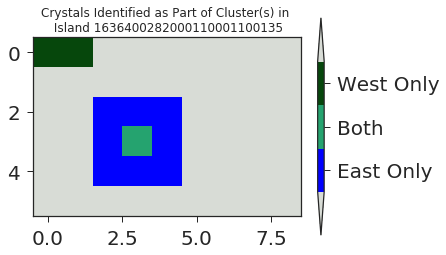

Unique island:  1636400282000110001100138 (entry 8500 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000110001100137 (entry 8501 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110001100139 (entry 8502 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000110001100136 (entry 8503 )
     KS Result:  0.9882610776652121
Unique island:  1636400282000110001100144 (entry 8504 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000110001100142 (entry 8505 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110001100140 (entry 8506 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000110001100141 (entry 8507 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000110001100145 (entry 8508 )
     KS Result:  0.8781816046495938
Unique island:  1636400282000110001100143 (entry 8509 )
     KS Result:  0.998265735388435
Unique island:  1636400282000110001100148 (entry 8510 )
     KS Result:  0.840248

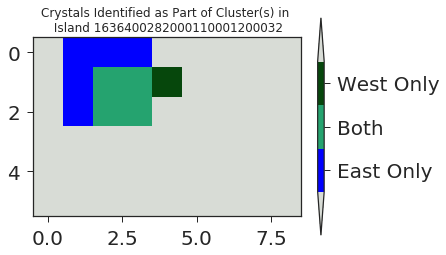

Unique island:  1636400282000110001200049 (entry 8564 )
     KS Result:  0.8781816046495938
Unique island:  1636400282000110001200019 (entry 8565 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110001200018 (entry 8566 )
     KS Result:  0.994241144886877
Unique island:  1636400282000110001200069 (entry 8567 )
     KS Result:  0.9200069139664129
Unique island:  1636400282000110001200057 (entry 8569 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000110001200052 (entry 8570 )
     KS Result:  0.9999992291718
Unique island:  1636400282000110001200025 (entry 8571 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000110001200035 (entry 8572 )
     KS Result:  0.4575098231776886


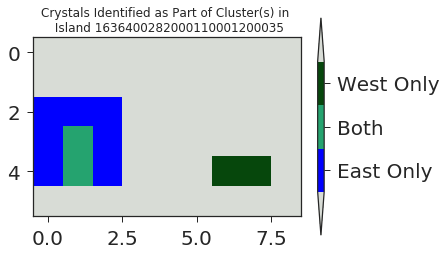

Unique island:  1636400282000110001200065 (entry 8573 )
     KS Result:  0.999965230654072
Unique island:  1636400282000110001200042 (entry 8574 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000110001200056 (entry 8575 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110001200064 (entry 8576 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000110001200044 (entry 8577 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000110001200045 (entry 8578 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000110001200051 (entry 8579 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000110001200063 (entry 8580 )
     KS Result:  0.9999913128204173
Unique island:  1636400282000110001200073 (entry 8581 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000110001200074 (entry 8582 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000110001200072 (entry 8583 )
     KS Result:  0.963945

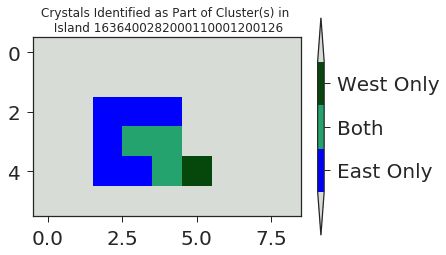

Unique island:  1636400282000110001200128 (entry 8639 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000110001200130 (entry 8640 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000110001200125 (entry 8641 )
     KS Result:  0.994241144886877
Unique island:  1636400282000110001200131 (entry 8642 )
     KS Result:  0.998265735388435
Unique island:  1636400282000110001200132 (entry 8643 )
     KS Result:  0.963945243731486
Unique island:  1636400282000110001200133 (entry 8644 )
     KS Result:  0.9919638849816804
Unique island:  1636400282000110001200134 (entry 8645 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000110001300051 (entry 8646 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000110001300027 (entry 8647 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000110001300014 (entry 8648 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110001300017 (entry 8649 )
     KS Result:  0.95696473

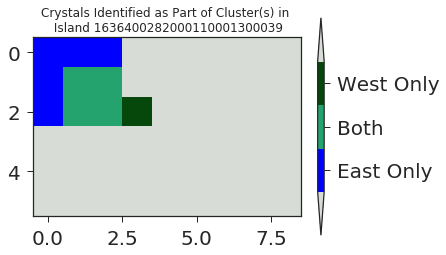

Unique island:  1636400282000110001300054 (entry 8661 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000110001300048 (entry 8662 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110001300035 (entry 8663 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000110001300052 (entry 8664 )
     KS Result:  0.998265735388435
Unique island:  1636400282000110001300055 (entry 8665 )
     KS Result:  0.999965230654072
Unique island:  1636400282000110001300049 (entry 8666 )
     KS Result:  0.9180184255186957
Unique island:  1636400282000110001300021 (entry 8667 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000110001300041 (entry 8668 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000110001300018 (entry 8669 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000110001300019 (entry 8670 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110001300015 (entry 8671 )
     KS Result:  1.0
Uniqu

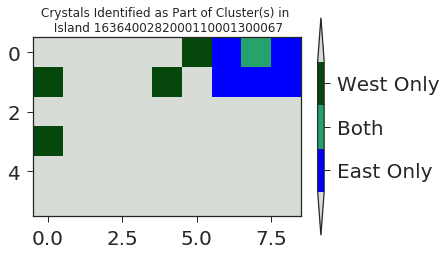

Unique island:  1636400282000110001300083 (entry 8710 )
     KS Result:  0.998265735388435
Unique island:  1636400282000110001300080 (entry 8711 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000110001300079 (entry 8712 )
     KS Result:  0.9762589132952211
Unique island:  1636400282000110001300078 (entry 8713 )
     KS Result:  0.796412508578516
Unique island:  1636400282000110001300082 (entry 8714 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000110001300094 (entry 8715 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000110001300085 (entry 8716 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000110001300097 (entry 8717 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000110001300099 (entry 8718 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000110001300101 (entry 8719 )
     KS Result:  0.9180184255186957
Unique island:  1636400282000110001300092 (entry 8720 )
     KS Result:  0.9180184

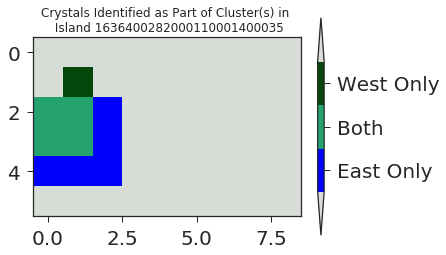

Unique island:  1636400282000110001400049 (entry 8779 )
     KS Result:  0.978035935356541
Unique island:  1636400282000110001400038 (entry 8780 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000110001400057 (entry 8781 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000110001400048 (entry 8782 )
     KS Result:  0.9907163119347335
Unique island:  1636400282000110001400062 (entry 8783 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000110001400031 (entry 8784 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000110001400012 (entry 8785 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000110001400016 (entry 8786 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000110001400036 (entry 8787 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000110001400055 (entry 8788 )
     KS Result:  0.9999999955914529
Unique island:  1636400282000110001400039 (entry 8789 )
     KS Result:  0.644693

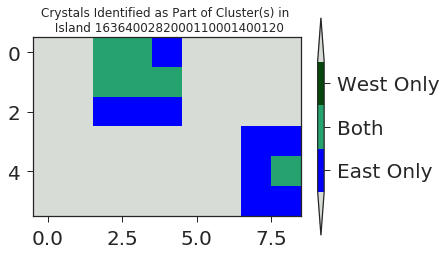

Unique island:  1636400282000110001400107 (entry 8853 )
     KS Result:  0.9780359353565411
Unique island:  1636400282000110001400097 (entry 8854 )
     KS Result:  0.9762589132952212
Unique island:  1636400282000110001400100 (entry 8855 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000110001400089 (entry 8856 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000110001400092 (entry 8857 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110001400090 (entry 8858 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110001400103 (entry 8859 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000110001400108 (entry 8860 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000110001400109 (entry 8861 )
     KS Result:  0.6870911965696748
Unique island:  1636400282000110001400095 (entry 8862 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110001400105 (entry 8863 )
     KS Result:  0.99963

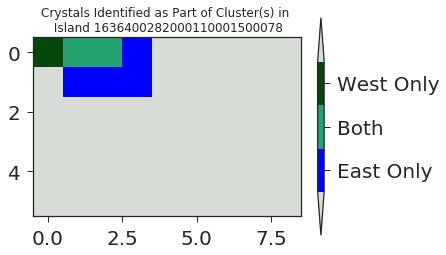

Unique island:  1636400282000110001500089 (entry 8969 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000110001500080 (entry 8970 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000110001500086 (entry 8971 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000110001500090 (entry 8972 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000110001500085 (entry 8973 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000110001500092 (entry 8974 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000110001500079 (entry 8975 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000110001500093 (entry 8976 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110001500087 (entry 8977 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000110001500088 (entry 8978 )
     KS Result:  0.765763173908239
Unique island:  1636400282000110001500098 (entry 8979 )
     KS Result:  0.903008

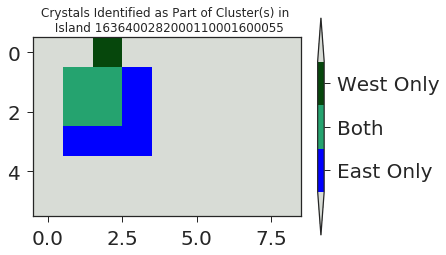

Unique island:  1636400282000110001600046 (entry 9080 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110001600070 (entry 9081 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110001600069 (entry 9082 )
     KS Result:  0.998265735388435
Unique island:  1636400282000110001600067 (entry 9083 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000110001600071 (entry 9084 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000110001600073 (entry 9085 )
     KS Result:  0.998265735388435
Unique island:  1636400282000110001600075 (entry 9086 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000110001600072 (entry 9087 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110001600076 (entry 9088 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000110001600089 (entry 9089 )
     KS Result:  0.998265735388435
Unique island:  1636400282000110001600078 (entry 9090 )
     KS Result:  0.99988673

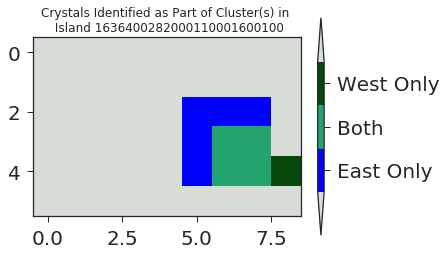

Unique island:  1636400282000110001600103 (entry 9113 )
     KS Result:  0.999965230654072
Unique island:  1636400282000110001600099 (entry 9114 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000110001600093 (entry 9115 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000110001600097 (entry 9116 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000110001600104 (entry 9117 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110001600107 (entry 9118 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110001600105 (entry 9119 )
     KS Result:  0.5788145276377622


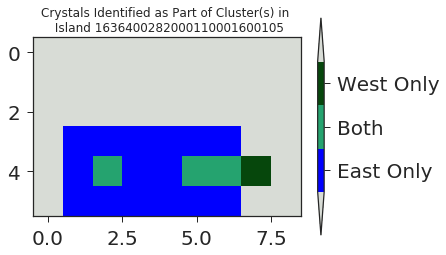

Unique island:  1636400282000110001600106 (entry 9121 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000110001600111 (entry 9122 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000110001600108 (entry 9123 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000110001600109 (entry 9124 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000110001600110 (entry 9125 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110001600112 (entry 9126 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000110001600117 (entry 9127 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000110001600115 (entry 9128 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000110001600113 (entry 9129 )
     KS Result:  0.994241144886877
Unique island:  1636400282000110001600114 (entry 9130 )
     KS Result:  0.9515985792330525
Unique island:  1636400282000110001600116 (entry 9131 )
     KS Result:  0.847488

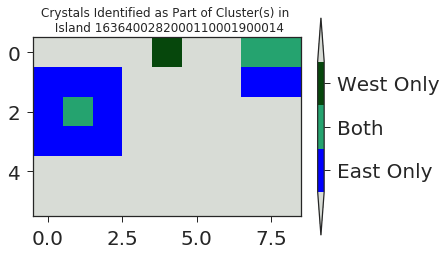

Unique island:  1636400282000110001900042 (entry 9402 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000110001900038 (entry 9403 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000110001900039 (entry 9404 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110001900019 (entry 9405 )
     KS Result:  0.9324454652858937
Unique island:  1636400282000110001900061 (entry 9406 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000110001900043 (entry 9407 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000110001900017 (entry 9408 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000110001900070 (entry 9409 )
     KS Result:  0.9513037360389418
Unique island:  1636400282000110001900031 (entry 9410 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000110001900046 (entry 9411 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000110001900066 (entry 9412 )
     KS Result:  0.64469

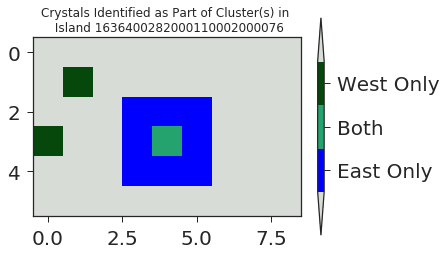

Unique island:  1636400282000110002000088 (entry 9582 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000110002000097 (entry 9583 )
     KS Result:  0.994241144886877
Unique island:  1636400282000110002000075 (entry 9584 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000110002000090 (entry 9585 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000110002000082 (entry 9586 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000110002000102 (entry 9587 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000110002000087 (entry 9588 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000110002000077 (entry 9589 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110002000096 (entry 9590 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000110002000093 (entry 9591 )
     KS Result:  0.8474884542294501
Unique island:  1636400282000110002000109 (entry 9592 )
     KS Result:  0.549326

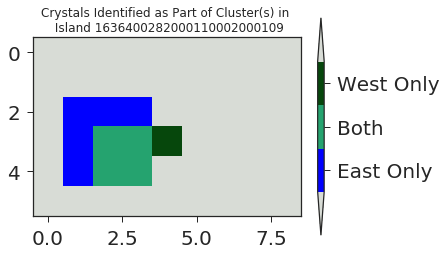

Unique island:  1636400282000110002000089 (entry 9593 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000110002000100 (entry 9594 )
     KS Result:  0.998265735388435
Unique island:  1636400282000110002000103 (entry 9595 )
     KS Result:  0.9793631144957664
Unique island:  1636400282000110002000107 (entry 9596 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000110002000084 (entry 9597 )
     KS Result:  0.765763173908239
Unique island:  1636400282000110002000083 (entry 9598 )
     KS Result:  0.759097838865462
Unique island:  1636400282000110002000104 (entry 9599 )
     KS Result:  0.7657631739082391
Unique island:  1636400282000110002000094 (entry 9600 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000110002000110 (entry 9601 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000110002000105 (entry 9602 )
     KS Result:  0.8742486254679956
Unique island:  1636400282000110002000095 (entry 9604 )
     KS Result:  0.99480102

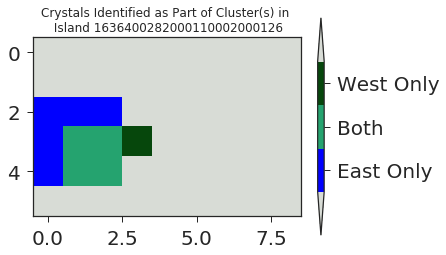

Unique island:  1636400282000110002000133 (entry 9625 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000110002000129 (entry 9626 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000110002000125 (entry 9627 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000110002000128 (entry 9628 )
     KS Result:  0.6446936296254577
Unique island:  1636400282000110002000130 (entry 9629 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000110002000135 (entry 9630 )
     KS Result:  0.9998867320300575
Unique island:  1636400282000110002000127 (entry 9631 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000110002000132 (entry 9632 )
     KS Result:  0.5493264419710108


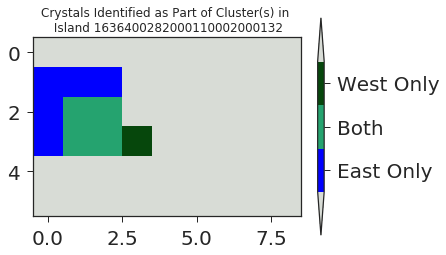

Unique island:  1636400282000110002000134 (entry 9633 )
     KS Result:  0.9999042837898172
Unique island:  1636400282000110002000136 (entry 9634 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110002000138 (entry 9635 )
     KS Result:  0.998265735388435
Unique island:  1636400282000110002000140 (entry 9636 )
     KS Result:  0.8402484746377933
Unique island:  1636400282000110002000141 (entry 9637 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000110002000142 (entry 9638 )
     KS Result:  0.9999408738110138
Unique island:  1636400282000110002000144 (entry 9639 )
     KS Result:  0.9513037360389418
Unique island:  1636400282000110002000137 (entry 9640 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000110002000143 (entry 9641 )
     KS Result:  0.765763173908239
Unique island:  1636400282000110002000146 (entry 9642 )
     KS Result:  0.9513037360389418
Unique island:  1636400282000110002000145 (entry 9643 )
     KS Result:  0.7657631

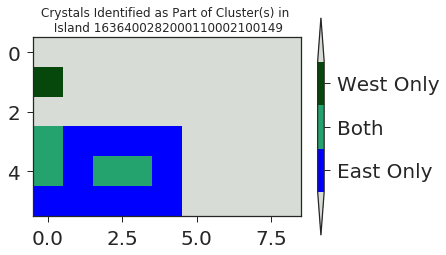

Unique island:  1636400282000110002100150 (entry 9794 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000110002100152 (entry 9795 )
     KS Result:  0.9919638849816804
Unique island:  1636400282000110002200028 (entry 9796 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000110002200064 (entry 9797 )
     KS Result:  0.9973423265625655
Unique island:  1636400282000110002200055 (entry 9799 )
     KS Result:  0.999965230654072
Unique island:  1636400282000110002200009 (entry 9800 )
     KS Result:  0.9999842232338398
Unique island:  1636400282000110002200037 (entry 9801 )
     KS Result:  0.9793631144957665
Unique island:  1636400282000110002200036 (entry 9802 )
     KS Result:  0.9582639842956672
Unique island:  1636400282000110002200033 (entry 9803 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000110002200059 (entry 9804 )
     KS Result:  0.9996332921584052
Unique island:  1636400282000110002200024 (entry 9805 )
     KS Result:  0.903008

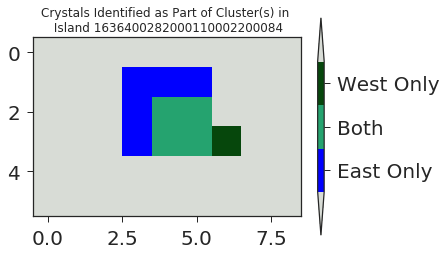

Unique island:  1636400282000110002200078 (entry 9867 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110002200091 (entry 9868 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000110002200081 (entry 9869 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000110002200087 (entry 9870 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110002200089 (entry 9871 )
     KS Result:  0.6870911965696748
Unique island:  1636400282000110002200095 (entry 9872 )
     KS Result:  0.870945902632274
Unique island:  1636400282000110002200094 (entry 9873 )
     KS Result:  0.8884604030744511
Unique island:  1636400282000110002200100 (entry 9874 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000110002200099 (entry 9875 )
     KS Result:  0.9948010273772511
Unique island:  1636400282000110002200093 (entry 9876 )
     KS Result:  0.9919638849816804
Unique island:  1636400282000110002200103 (entry 9877 )
     KS Result:  0.918018

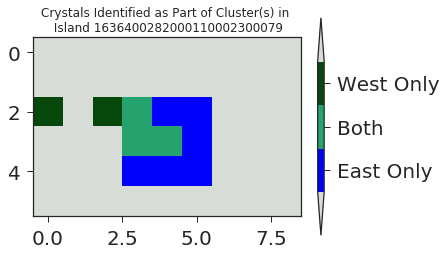

Unique island:  1636400282000110002300086 (entry 9965 )
     KS Result:  0.9524779094415624
Unique island:  1636400282000110002300087 (entry 9967 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110002300077 (entry 9968 )
     KS Result:  0.6870911965696747
Unique island:  1636400282000110002300093 (entry 9969 )
     KS Result:  0.9180184255186958
Unique island:  1636400282000110002300083 (entry 9970 )
     KS Result:  0.9030083679726315
Unique island:  1636400282000110002300089 (entry 9971 )
     KS Result:  0.9569647356345463
Unique island:  1636400282000110002300088 (entry 9972 )
     KS Result:  0.998265735388435
Unique island:  1636400282000110002300103 (entry 9973 )
     KS Result:  0.9904917099508751
Unique island:  1636400282000110002300098 (entry 9974 )
     KS Result:  0.9639452437314864
Unique island:  1636400282000110002300092 (entry 9975 )
     KS Result:  0.9324454652858934
Unique island:  1636400282000110002300091 (entry 9976 )
     KS Result:  0.765763

Error in <TH2D::KolmogorovTest>: Integral is zero for h2=h2

Error in <TH2D::KolmogorovTest>: Integral is zero for h2=h2

Error in <TH2D::KolmogorovTest>: Integral is zero for h2=h2



In [6]:
dingbefore = 0
ksVec = []

lowVec = []

for i, entry in enumerate(teast):
    
    if i < 0:
        continue
    if i > 10000:
        break
    
    counter = 0
    ding = constructUniqueIDeast(entry)
    if (dingbefore == ding):
        continue
        
    print("Unique island: ", ding, "(entry", i, ")")
    
    crystalsEast = [x for x in entry.crystalsEast]
    fout = r.TFile("temp_tree_storage.root","recreate")
    
    teast_partial = teast.CopyTree( constructConditionFromUniqueIDEast(ding) )
    for k, entry3 in enumerate(teast_partial):
        dong = constructUniqueIDeast(entry3)
        if ding == dong:
#            print("     Found another island with this unique ID. Adding their crystals together:")
#            print("          ",crystalsEast)
            crystalsEast += [x for x in entry3.crystalsEast]
#            print("          ",crystalsEast)
    
    crystalsWest = []
    twest_partial = twest.CopyTree( constructConditionFromUniqueIDWest(ding) )
    for j, entry2 in enumerate(twest_partial):
        dong = constructUniqueIDwest(entry2)
        if (ding == dong):
            counter = counter + 1
#            print("     Found Match (", i, j, counter,")")
#            print("         East: ", crystalsEast)
#            print("         West: ", [x for x in entry2.crystalsWest])
            crystalsWest += [x for x in entry2.crystalsWest]
            
#    imshowCompare( toMap(crystalsEast), toMap(crystalsWest), True, ding)
        
    eastMap = toMap(crystalsEast)
    westMap = toMap(crystalsWest)
    idnum = ding

    dingbefore = ding

    h = r.TH2D("h","east",9,0,9,6,0,6)
    for iy, y in enumerate(eastMap):
        for ix, x in enumerate(y):
            if(x > 0.1):
                h.Fill(ix,iy)
    h2 = r.TH2D("h2","west",9,0,9,6,0,6)
    for iy, y in enumerate(westMap):
        for ix, x in enumerate(y):
            if(x > 0.1):
                h2.Fill(ix,iy)
                
    ksi = h.KolmogorovTest(h2)
    print("     KS Result: ", ksi)
    ksVec.append(ksi)
    
    if(ksi < 0.6):
        imshowCompare( toMap(crystalsEast), toMap(crystalsWest), True, ding)
        lowVec.append((ding, ksi))

[(1636400282000020000100077, 0.5493264419710108), (1636400282000020000200031, 0.5493264419710108), (1636400282000020000300073, 0.5493264419710108), (1636400282000020000400039, 0.33639488021233704), (1636400282000020000600073, 0.5296714468087738), (1636400282000020000700089, 0.504120603962696), (1636400282000020000800088, 0.5296714468087738), (1636400282000020001000114, 0.5493264419710108), (1636400282000020001100006, 0.5821433529824666), (1636400282000020001100099, 0.34464583914769875), (1636400282000020001300073, 0.592502831138744), (1636400282000020001300133, 0.5598535120830147), (1636400282000020001500060, 0.5466892136247964), (1636400282000020001500017, 0.5493264419710108), (1636400282000020001500081, 0.5493264419710108), (1636400282000020001600037, 0.5910986832397158), (1636400282000020001600052, 0.5493264419710108), (1636400282000020001600080, 0.5296714468087739), (1636400282000020001700039, 0.5493264419710108), (1636400282000020001700042, 0.0), (1636400282000020001700110, 0.5493

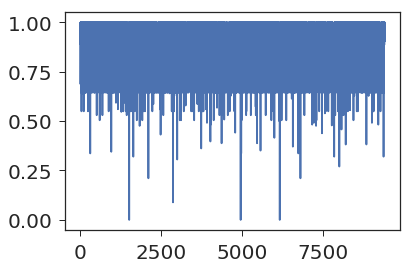

In [7]:
print(lowVec)

plt.plot(ksVec)
plt.show()

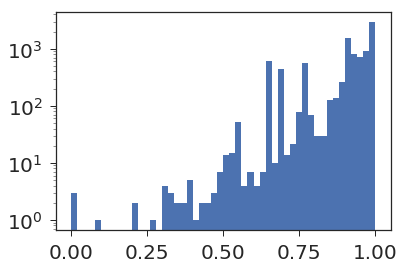

In [8]:
plt.hist(ksVec,bins=50,range=(0,1))
plt.yscale('log')
plt.show()